In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pointbiserialr
import warnings

warnings.filterwarnings('ignore')

In [2]:
def plot_kde(feature, split=None, xticks=None, xlim=None, target='target'):
    plt.figure(figsize=(10, 5))
    if split is None:
        for i in range(1, 7):
            ci = df[df[target] == i]
            ci[feature].plot(kind='kde', label=i)
            del ci
    else:
        df[df[target] <= split][feature].plot(kind='kde', label=1)
        df[df[target] > split][feature].plot(kind='kde', label=2)
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid(color='white')
    plt.xlabel(feature)
    plt.show()

def barplot(feature, ax=None, norm=False, figsize=None, target='target'):
    grouped = df.groupby([feature, target])[target].count()
    if norm:
        grouped /= df.groupby(target)[target].count()
    shape = grouped.index.levshape
    x = np.arange(1, 1 + shape[1])
    x_shift = np.linspace(-.4 + .4/shape[0], .4 - .4/shape[0], shape[0])
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    for i, idx in enumerate(grouped.index.unique(feature)):
        ax.bar(x + x_shift[i], grouped[idx], .8/shape[0], label=idx)
    ax.set_xlabel(target)
    if norm:
        ax.set_ylabel(feature.capitalize() + ' ratio')
    else:
        ax.set_ylabel(feature.capitalize() + ' count')
    ax.legend()

def barplots(feature, figsize=(18, 6), target='target'):
    fig, ax = plt.subplots(ncols=3, figsize=figsize)
    a = df.groupby(feature)[target].mean().plot(kind='bar', ax=ax[0])
    a.set_xlabel(feature.capitalize())
    a.set_ylabel('Target mean')
    barplot(feature, ax[1], target='target')
    barplot(feature, ax[2], norm=True, target='target')


# Data loading

In [3]:
df = pd.read_csv('vodafone_age_subset.csv')
df = df.drop(columns=['user_hash'])
df.columns = df.columns.str.lower()
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 115 columns):
 #    Column                       Dtype  
---   ------                       -----  
 0    calculation_method_id        int64  
 1    calls_count_in_weekdays      float64
 2    calls_duration_in_weekdays   float64
 3    calls_count_out_weekdays     float64
 4    calls_duration_out_weekdays  float64
 5    calls_count_in_weekends      float64
 6    calls_duration_in_weekends   float64
 7    calls_count_out_weekends     float64
 8    calls_duration_out_weekends  float64
 9    data_volume_weekdays         float64
 10   data_volume_weekends         float64
 11   lat_home                     float64
 12   lon_home                     float64
 13   oblast_post_home             object 
 14   raion_post_home              object 
 15   city_post_home               object 
 16   lat_quad_home                float64
 17   lon_quad_home                float64
 18   lat_work                

# EDA + preprocessing
## Column types

In [4]:
catrank = df.columns[(df.dtypes == 'object') | (df.dtypes == 'int64')]
num = df.columns[~df.columns.isin(catrank)]
catrank

Index(['calculation_method_id', 'oblast_post_home', 'raion_post_home',
       'city_post_home', 'oblast_post_work', 'raion_post_work',
       'city_post_work', 'device_brand', 'device_model', 'software_os_vendor',
       'software_os_name', 'software_os_version', 'device_type_rus', 'scoring',
       'car', 'gender', 'ecommerce_score', 'target'],
      dtype='object')

In [5]:
df.isna().sum().sum()

0

Seems like dataset has 0 null values, but that's not true because for some reason nulls here are filled with zeros. Like this:

## Column informativity

In [6]:
df.std().sort_values()

sberbank                  0.000000
steam_volume              0.023148
sunoil                    0.049277
jabber_volume             0.068234
flickr_volume             0.110846
                           ...    
avg_arpu                 99.804255
intagram_count          101.612722
data_volume_weekdays    143.934404
data_volume_weekends    145.125975
google_count            152.575225
Length: 102, dtype: float64

In [7]:
df.sberbank.value_counts()

0.0    21000
Name: sberbank, dtype: int64

In [8]:
for column in df.columns:
    print(column, df[column].value_counts().iloc[0])

calculation_method_id 10588
calls_count_in_weekdays 1449
calls_duration_in_weekdays 1449
calls_count_out_weekdays 1691
calls_duration_out_weekdays 1691
calls_count_in_weekends 2433
calls_duration_in_weekends 2433
calls_count_out_weekends 2962
calls_duration_out_weekends 2962
data_volume_weekdays 8552
data_volume_weekends 9414
lat_home 1295
lon_home 1295
oblast_post_home 3041
raion_post_home 3041
city_post_home 3041
lat_quad_home 1295
lon_quad_home 1295
lat_work 962
lon_work 962
oblast_post_work 3289
raion_post_work 3289
city_post_work 3289
lat_quad_work 962
lon_quad_work 962
device_brand 5208
device_model 1779
software_os_vendor 11788
software_os_name 11774
software_os_version 6810
device_type_rus 15611
sim_count 7203
avg_arpu 105
roum 17495
phone_value 13547
scoring 5377
car 11193
gender 11555
lifetime 110
how_long_same_model 5620
ecommerce_score 15000
privat 10323
oschadbank 17578
alfabank 18628
ukrsotbank 20658
otp 20327
ukrgasbank 20553
raiffeisen 19436
pivdennyi 20802
ideabank 206

In [9]:
df = df.drop(columns='sberbank')

## Target distribution

1     548
2    1076
3    4047
4    6020
5    6029
6    3280
Name: target, dtype: int64

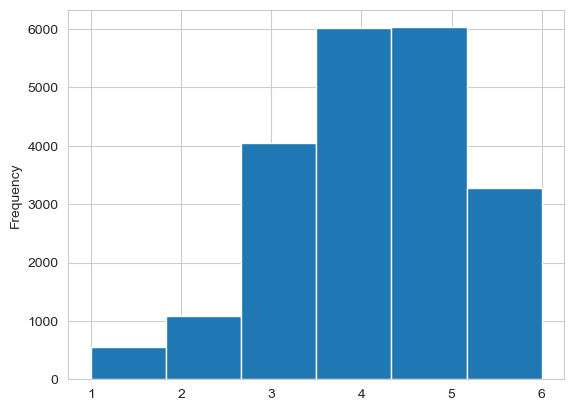

In [10]:
df.target.plot(kind='hist', bins=6)
df.target.value_counts().sort_index()

## Categorical analysis
### Scoring

In [11]:
df.scoring.value_counts()

HIGH_MEDIUM    5377
LOW            5153
MEDIUM         4928
VERY LOW       3032
HIGH           2506
0                 4
Name: scoring, dtype: int64

Only few missing values, they can be filled with mode.

In [12]:
df.scoring = df.scoring.replace({'0': 'HIGH_MEDIUM'})
df.scoring.value_counts()

HIGH_MEDIUM    5381
LOW            5153
MEDIUM         4928
VERY LOW       3032
HIGH           2506
Name: scoring, dtype: int64

Scoring can be considered as a rank variable and encoded respectfully.

Spearman correlation: 0.03099814982366467 p-value: 7.0269395348261655e-06


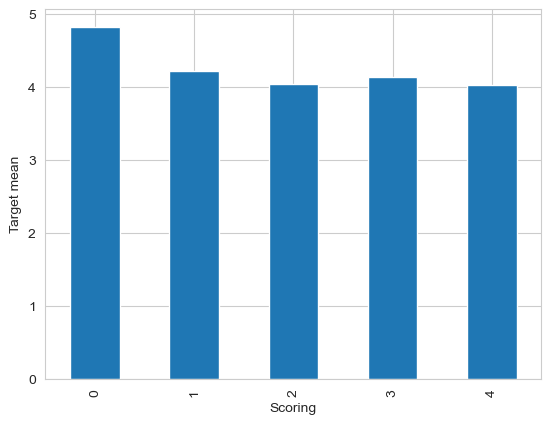

In [13]:
df.scoring = df.scoring.replace({'VERY LOW': 0, 'LOW': 1, 'MEDIUM': 2, 'HIGH_MEDIUM': 3, 'HIGH': 4})
a = df.groupby('scoring')['target'].mean().plot(kind='bar')
a.set_xlabel('Scoring')
a.set_ylabel('Target mean')
r = spearmanr(df['gender'], df['target'])
print('Spearman correlation:', r[0], 'p-value:', r[1])

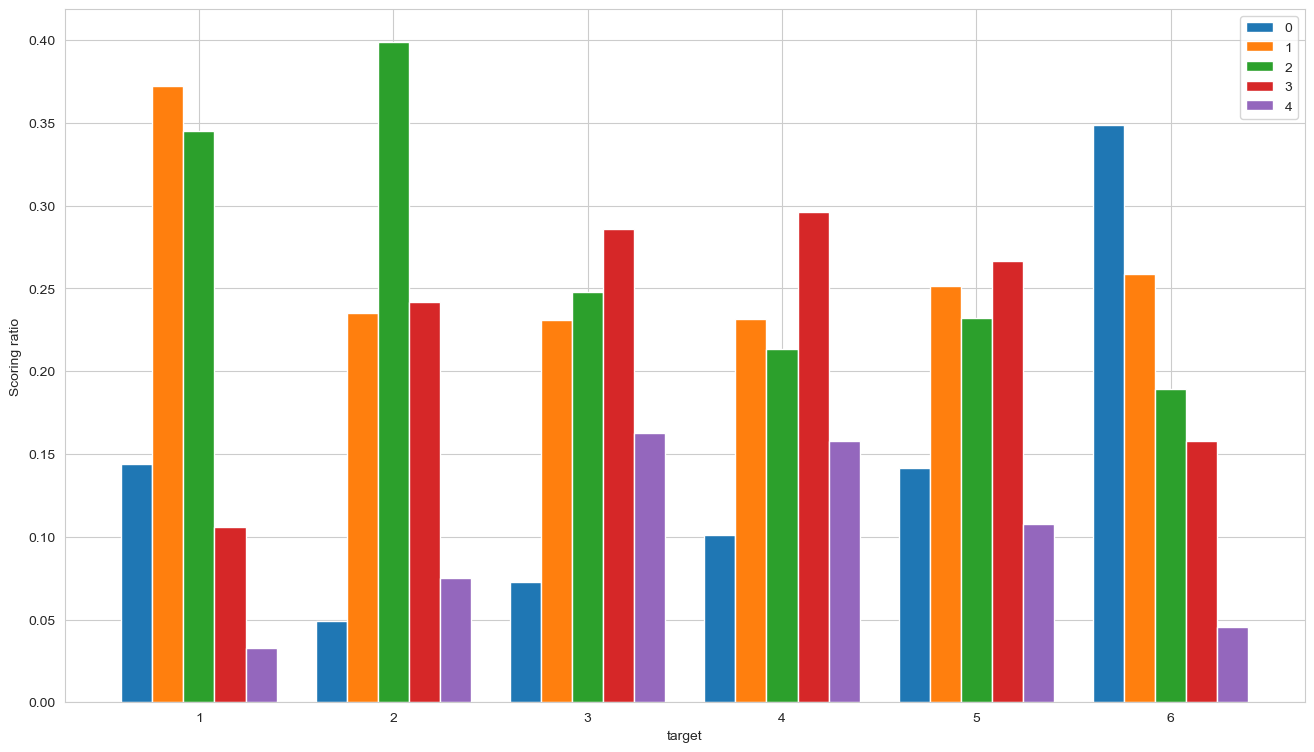

In [14]:
barplot('scoring', figsize=(16, 9), norm=True)

Children (~target=1) are getting paid so much nowadays...
Also lowest income group is older than others.

### Gender

In [15]:
r = pointbiserialr(df['gender'], df['target'])
print('Biserial correlation:', r[0], 'p-value:', r[1])
df.gender.value_counts()

Biserial correlation: 0.03152318857073978 p-value: 4.900392492659069e-06


0    11555
1     9445
Name: gender, dtype: int64

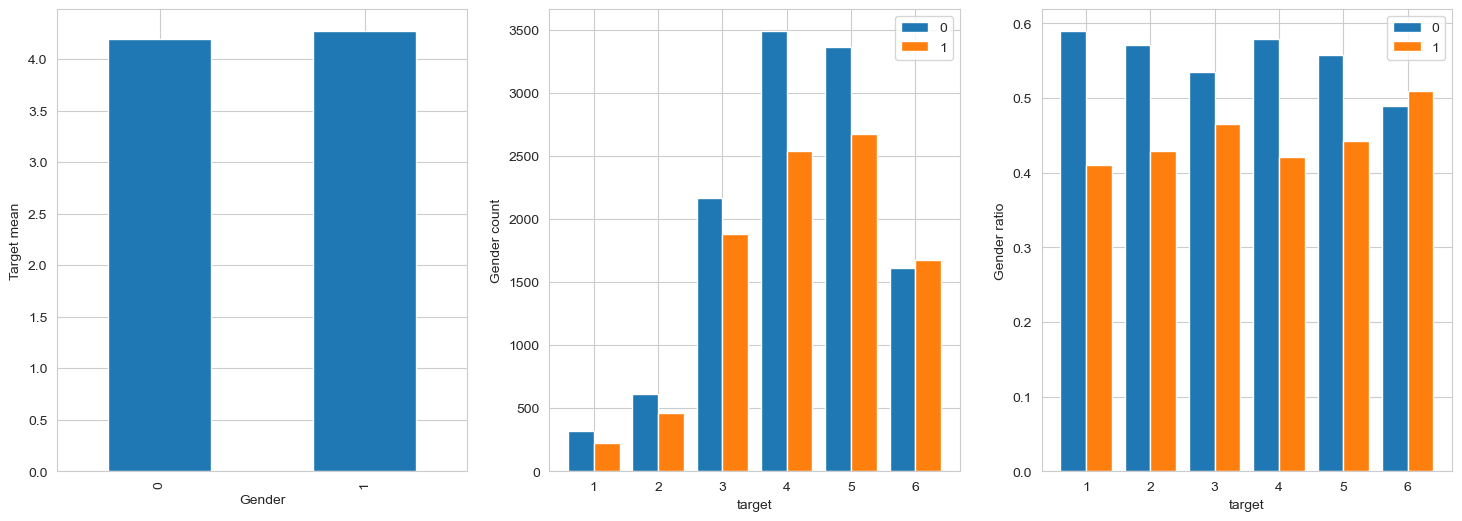

In [16]:
barplots('gender')

Nothing interesting there.

### Car

In [17]:
r = pointbiserialr(df['car'], df['target'])
print('Biserial correlation:', r[0], 'p-value:', r[1])
df.car.value_counts()

Biserial correlation: -0.011511418775258674 p-value: 0.09529210028117294


0    11193
1     9807
Name: car, dtype: int64

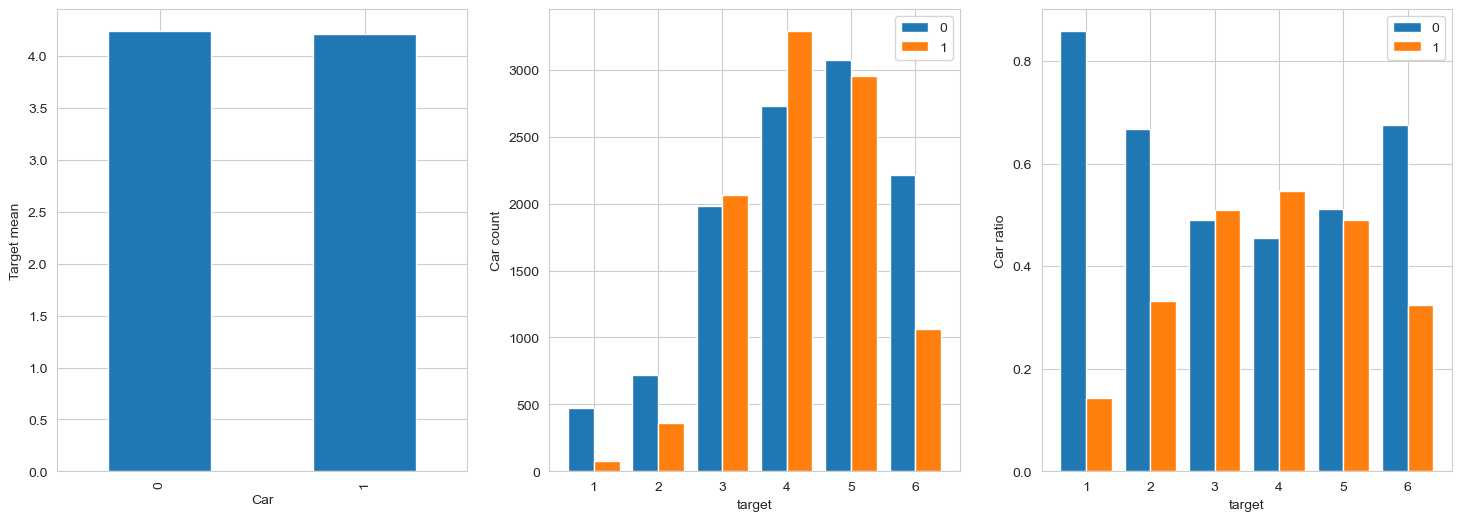

In [18]:
barplots('car')

Youngest and oldest groups tend to have no car.

### Ecommerse_score

In [19]:
r = pointbiserialr(df['ecommerce_score'], df['target'])
print('Biserial correlation:', r[0], 'p-value:', r[1])
df.ecommerce_score.value_counts()

Biserial correlation: -0.2577419356318997 p-value: 7.8907599e-316


0    15000
1     6000
Name: ecommerce_score, dtype: int64

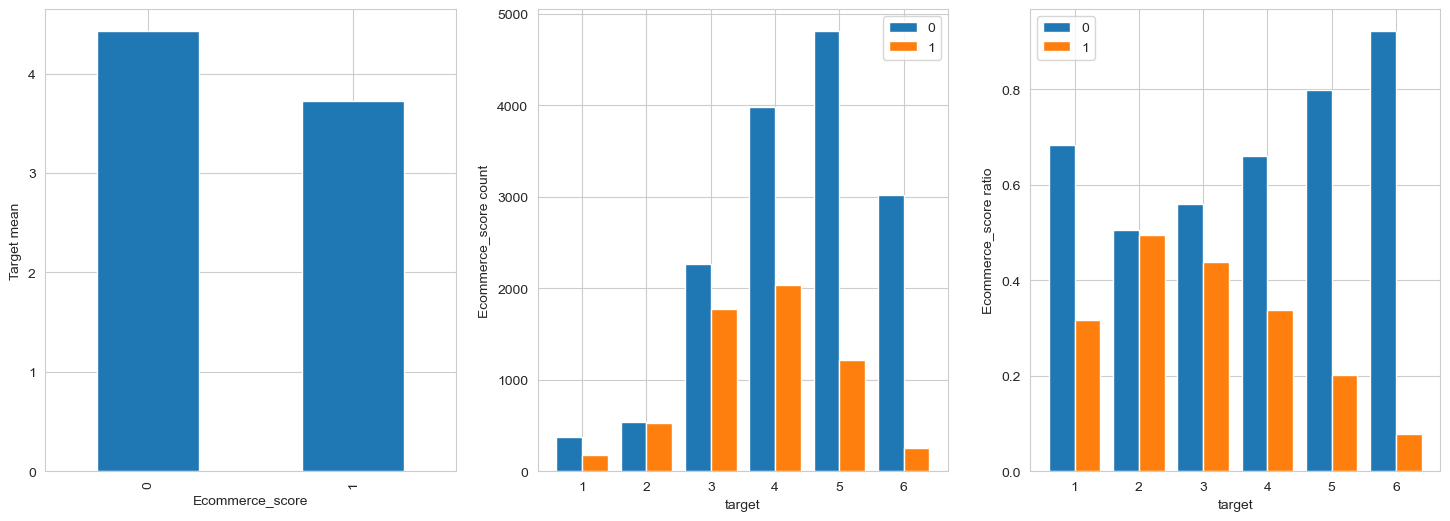

In [20]:
barplots('ecommerce_score')

Older subscribers are rarely buying online.

### Device type

In [21]:
r = pointbiserialr(df['device_type_rus'].replace({'0': 0, 'smartphone': 0, 'phone': 1}), df['target'])
print('Biserial correlation:', r[0], 'p-value:', r[1])
df.device_type_rus.value_counts()

Biserial correlation: 0.2446882307111817 p-value: 6.926107687830209e-284


smartphone    15611
phone          3610
0              1779
Name: device_type_rus, dtype: int64

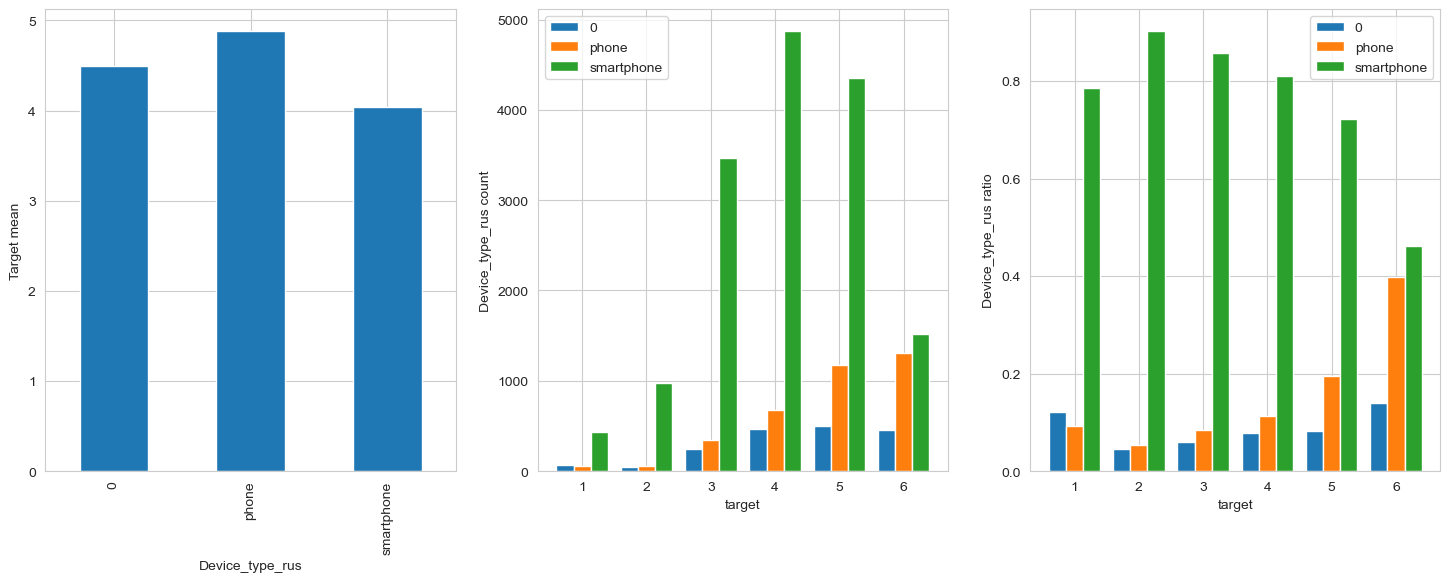

In [22]:
barplots('device_type_rus')

**Smart**phone users are younger in average.

### Calculation method

In [23]:
r = pointbiserialr(df['calculation_method_id'], df['target'])
print('Biserial correlation:', r[0], 'p-value:', r[1])
df.car.value_counts()

Biserial correlation: 0.361019576933029 p-value: 0.0


0    11193
1     9807
Name: car, dtype: int64

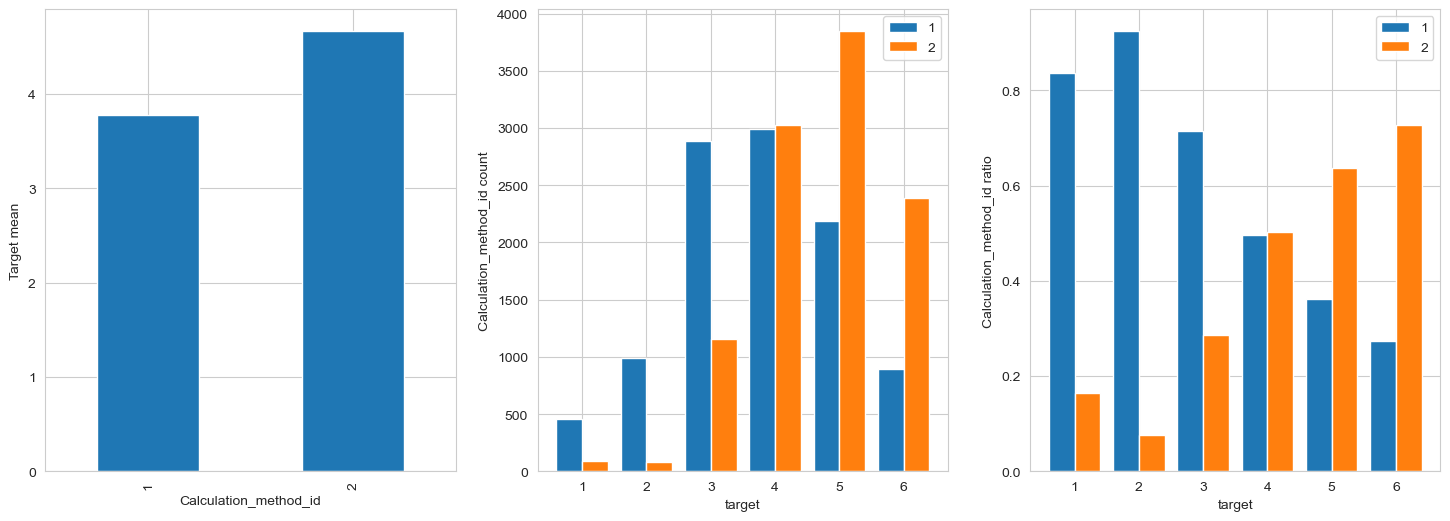

In [24]:
barplots('calculation_method_id')

Younger users are more often prepaid subscribers whereas older - contract.

### Phone OS

In [25]:
df.software_os_name.value_counts()

Android        11774
0               4172
iOS             2597
40              1106
30               566
Win Pho          215
YunOS            133
Asha              95
60.5              59
OSE               48
Bada              43
60.3.2            37
Nucleus           27
60.3.1            25
Windows           22
Anna              21
CyanogenMod       14
60.3              11
Belle              7
Win Mob            6
60.2.3             5
60.2.2             4
60.2.1             4
Linux              3
Garnet             3
UIQ 2.1            1
UIQ 3.0            1
Firefox            1
Name: software_os_name, dtype: int64

There are too many unpopular OS, they should be grouped into one.

In [26]:
df.software_os_name[~df.software_os_name.isin(['Android', '0', 'iOS'])] = 'Other'

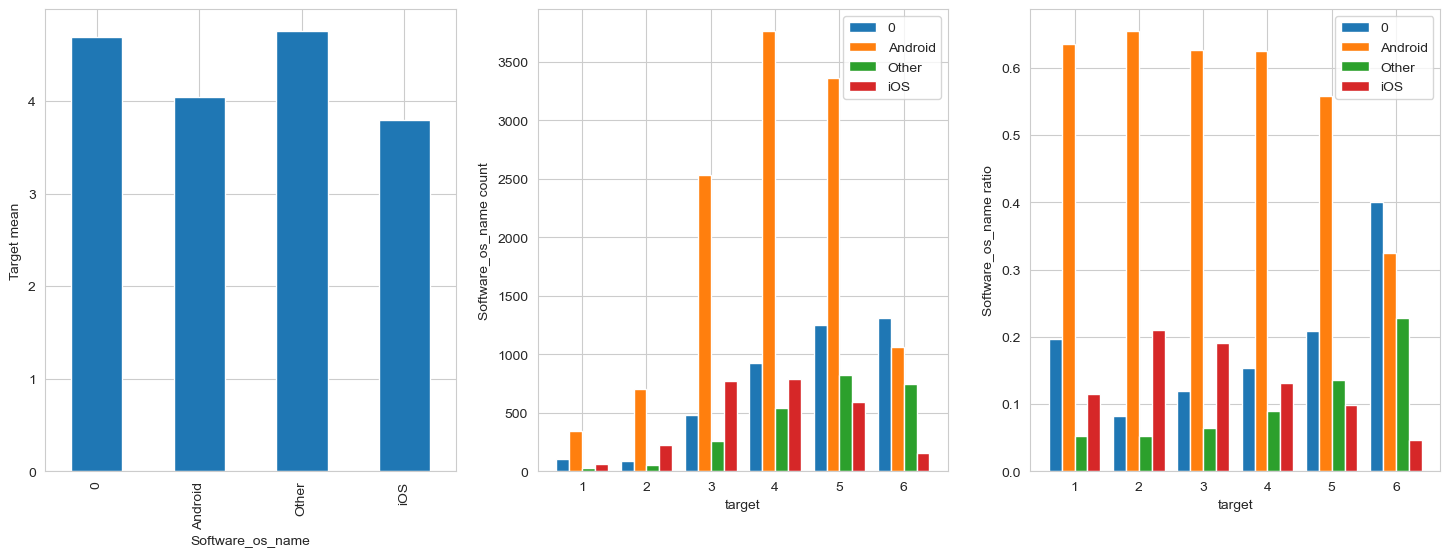

In [27]:
barplots('software_os_name')

Target distribution for devices with unknown OS is similar to devices with non-android/ios OS, so they can be also replaced with 'Other'.
Those whose device's OS is not android of ios or whose OS is unknown tend to be older.

In [28]:
df.software_os_name = df.software_os_name.replace({'0': 'Other'})

### Reducing unpopular values in other categorical columns

**Such as:**
    oblast_post_home, raion_post_home, city_post_home,
    oblast_post_work, raion_post_work, city_post_work,
    device_brand, device_model,
    software_os_vendor, software_os_version


In [29]:
def cut(feature, n):
    df[feature][~df[feature].isin(df[feature].value_counts()[:n].index)] = 'Other'

In [30]:
cut('oblast_post_home', 13)
cut('raion_post_home', 7)
cut('city_post_home', 6)
cut('oblast_post_work', 13)
cut('raion_post_work', 7)
cut('city_post_work', 6)
cut('device_brand', 8)
cut('software_os_vendor', 5)

OS version can be converted to numeric feature

In [31]:
def fixstr(s):
    try:
        i = s.index('.', s.index('.') + 1)
        return s[:i] + s[i+1:]
    except:
        return s
df.software_os_version = df.software_os_version.str.replace(r'[^0-9,.]+', '').apply(fixstr).replace({'61':'6'}).astype('float64')

Device model can be dropped because it has pathetic informativity.

In [32]:
print(df.device_model.value_counts())
df.drop(columns='device_model', inplace=True)

0                    1779
Redmi 4X              419
iPhone 6S (A1688)     316
SM-J510H DS           291
SM-J320H DS           267
                     ... 
LG-US997                1
K1                      1
6600i Slide             1
KangJia I128            1
LG-K350n                1
Name: device_model, Length: 2114, dtype: int64


### One-hot encoding of each categorical(not rank) feature

In [33]:
cat = df.columns[df.dtypes == 'object']
cat

Index(['oblast_post_home', 'raion_post_home', 'city_post_home',
       'oblast_post_work', 'raion_post_work', 'city_post_work', 'device_brand',
       'software_os_vendor', 'software_os_name', 'device_type_rus'],
      dtype='object')

In [34]:
df = pd.get_dummies(df, columns=cat)
df.head()

,calculation_method_id,calls_count_in_weekdays,calls_duration_in_weekdays,calls_count_out_weekdays,calls_duration_out_weekdays,calls_count_in_weekends,calls_duration_in_weekends,calls_count_out_weekends,calls_duration_out_weekends,data_volume_weekdays,...,software_os_vendor_Google,software_os_vendor_Nokia,software_os_vendor_Other,software_os_vendor_Samsung,software_os_name_Android,software_os_name_Other,software_os_name_iOS,device_type_rus_0,device_type_rus_phone,device_type_rus_smartphone
0,2,10.87,32.025,17.74,40.819,7.00,21.463,11.13,20.427,154.837,...,1,0,0,0,1,0,0,0,0,1
1,1,0.91,1.346,0.48,0.546,0.25,0.688,0.75,0.708,53.639,...,1,0,0,0,1,0,0,0,0,1
2,2,0.00,0.000,0.00,0.000,0.00,0.000,0.00,0.000,0.000,...,0,0,0,0,0,1,0,0,1,0
3,2,7.39,30.278,11.00,44.182,5.00,20.008,8.38,32.385,0.000,...,0,1,0,0,0,1,0,0,1,0
4,1,0.43,0.996,0.70,1.609,2.25,3.115,0.00,0.000,0.000,...,1,0,0,0,1,0,0,0,0,1


In [35]:
df.dtypes

calculation_method_id            int64
calls_count_in_weekdays        float64
calls_duration_in_weekdays     float64
calls_count_out_weekdays       float64
calls_duration_out_weekdays    float64
                                ...   
software_os_name_Other           uint8
software_os_name_iOS             uint8
device_type_rus_0                uint8
device_type_rus_phone            uint8
device_type_rus_smartphone       uint8
Length: 182, dtype: object

## Correlation analysis

In [36]:
def plot_moving_average(feature, n=3, window=100, bins=30, min_periods=25, lims=(None, None), target='target'):
    d = df[[feature, target]].sort_values(feature)
    d['mavr'] = d[target].rolling(window=window, min_periods=min_periods).mean()
    for i in range(1, n):
        d['mavr'] = d['mavr'].rolling(window=window, min_periods=min_periods).mean()
    if lims[0] != None:
        d = d[d[feature] >= lims[0]]
    if lims[1] != None:
        d = d[d[feature] <= lims[1]]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)
    axes[0].plot(d[feature], d['mavr'])
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Moving average of ' + target)
    axes[0].set_title(f'Moving average of {target} over the values of {feature}')

    axes[1].hist(d[feature], bins=bins)
    axes[1].set_xlabel('Histogram of ' + feature)

### Correlations with target column

In [37]:
corrs = pd.DataFrame(columns=df.columns).transpose()
for c in df.columns:
    corrs.loc[c, 'c'], corrs.loc[c, 'p'] = spearmanr(df['target'], df[c])
corrs['absc'] = corrs.c.abs()
corrs = corrs.sort_values('absc', ascending=False)
corrs

,c,p,absc
target,1.000000,0.000000,1.000000
instagram_volume,-0.390724,0.000000,0.390724
intagram_count,-0.385049,0.000000,0.385049
data_volume_weekdays,-0.375487,0.000000,0.375487
calculation_method_id,0.359041,0.000000,0.359041
...,...,...,...
pravexbank,0.002307,0.738159,0.002307
raion_post_home_Дніпро,-0.002230,0.746596,0.002230
amic,0.001734,0.801557,0.001734
banks_sms_count,-0.001072,0.876605,0.001072


Let's get a closer look at the strongest correlations.

#### Columns of type _volume, _count

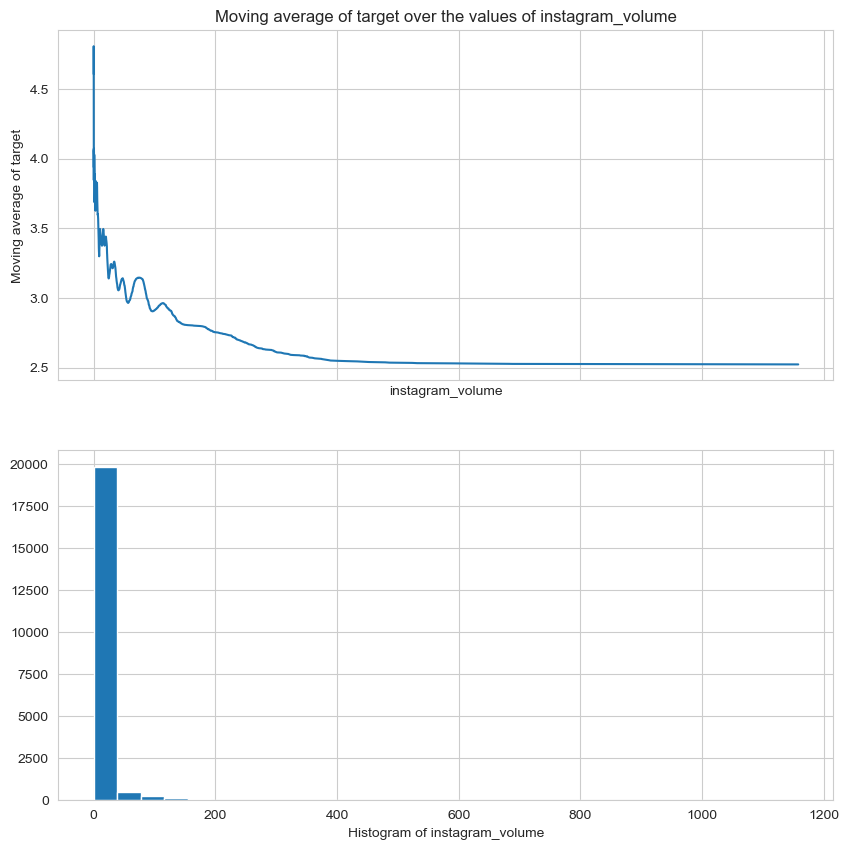

In [38]:
plot_moving_average('instagram_volume')

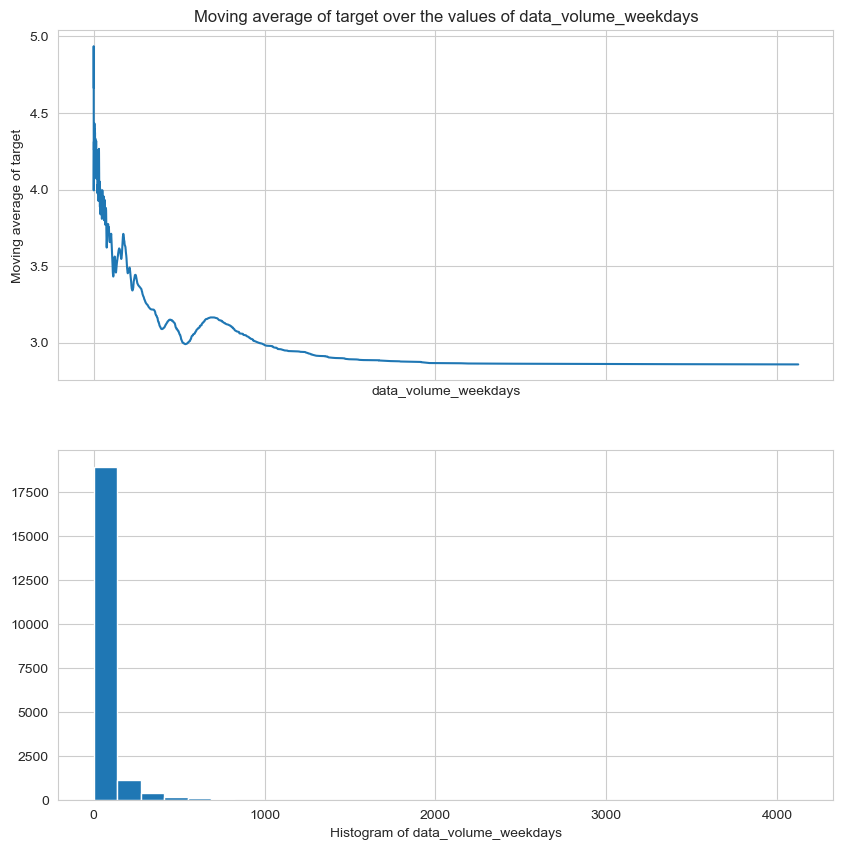

In [39]:
plot_moving_average('data_volume_weekdays')

All these columns have 0 as most common value by far and similar, kinda "hyperbolic" moving average plot.

#### Lifetime

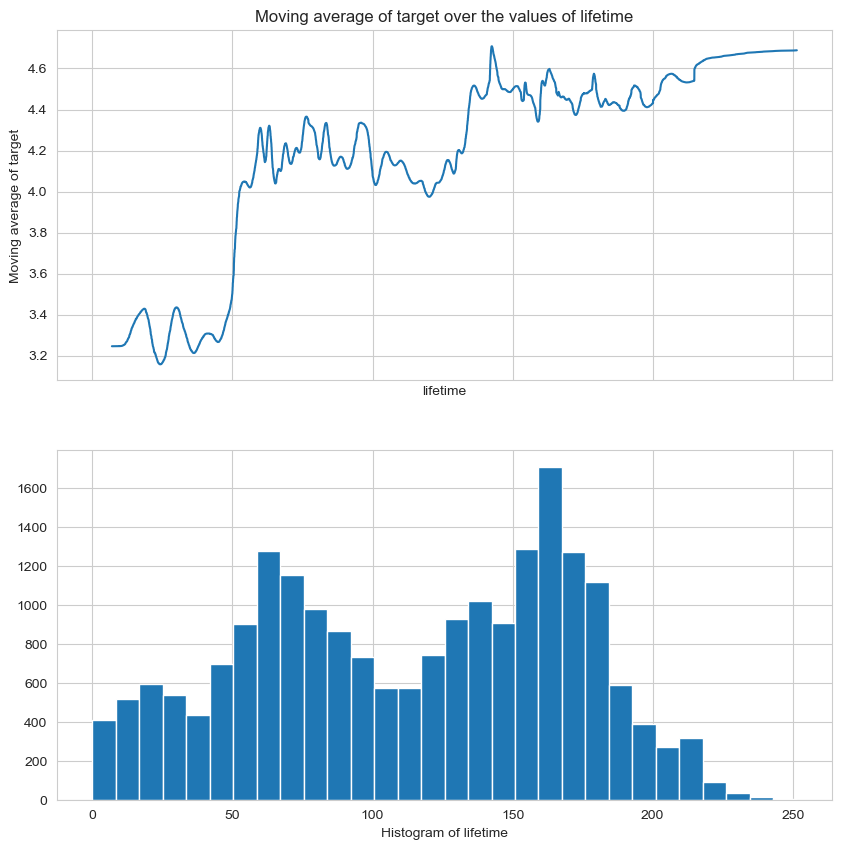

In [40]:
plot_moving_average('lifetime', 15)

One might see a clear positive correlation here.

#### OS version

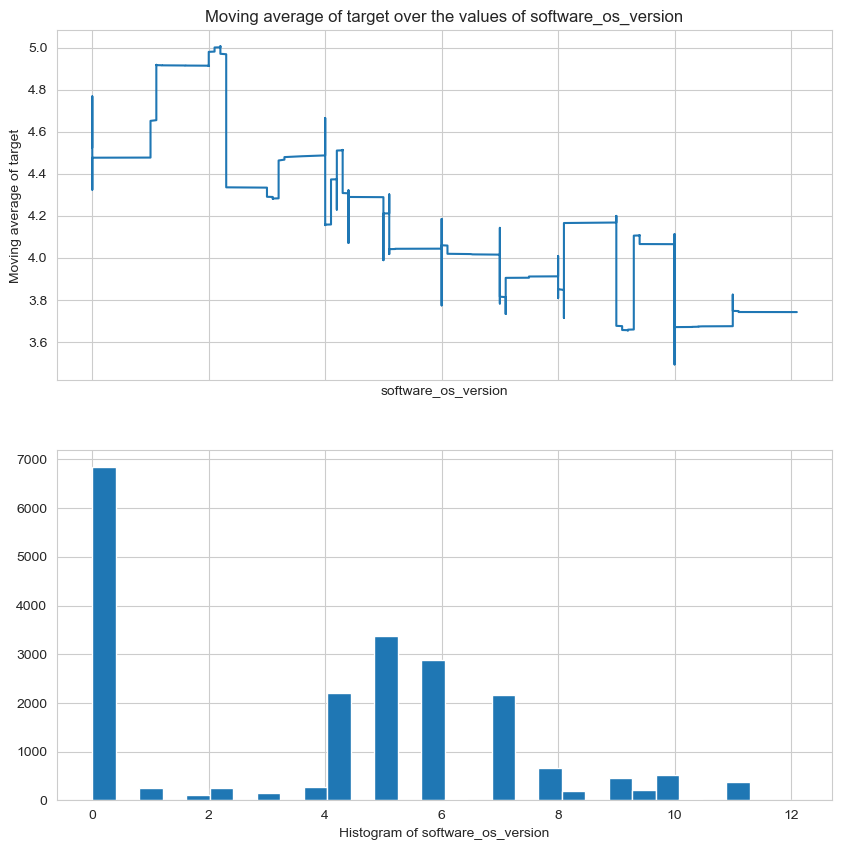

In [41]:
plot_moving_average('software_os_version')

The older you get, the older your os becomes.

#### ARPU

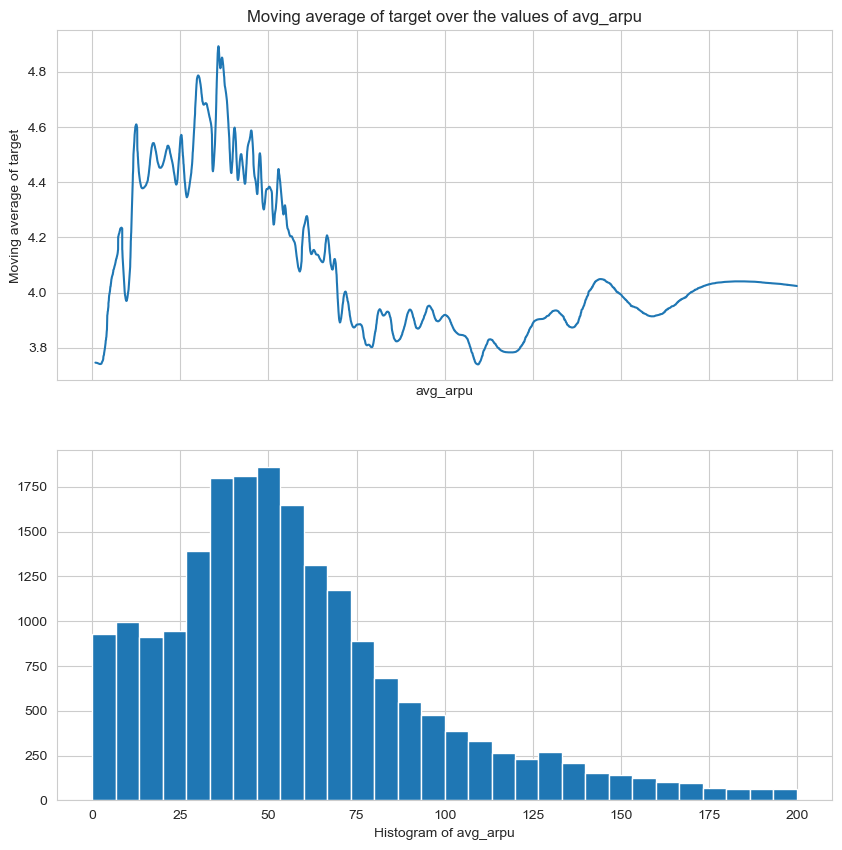

In [42]:
plot_moving_average('avg_arpu', 10, lims=(0, 200))

As amount of roaming and other extra services increases, average age of user initially grows and then falls.

#### Sms amount from Oschadbank.

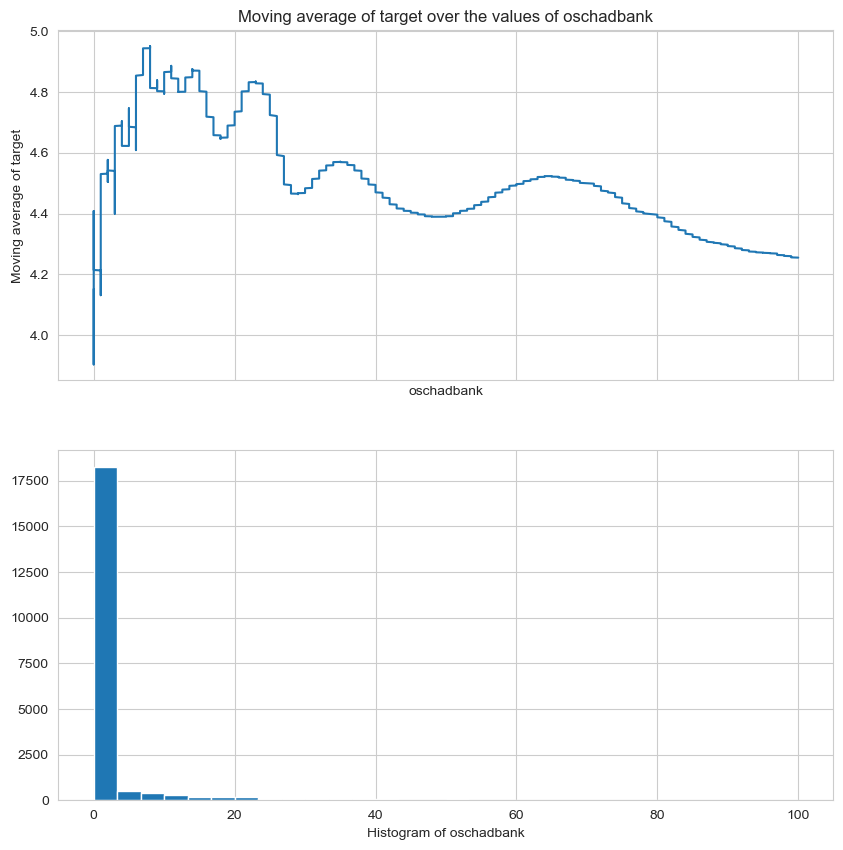

In [43]:
plot_moving_average('oschadbank', lims=(0, 100))

Vastly amount of users aren't using oschadbank, and those who are, tend to be older.

## TSNE

In [44]:
from sklearn.manifold import TSNE
X = TSNE(perplexity=25).fit_transform(df.drop(columns='target'))
y = df.target - 1

<Axes: >

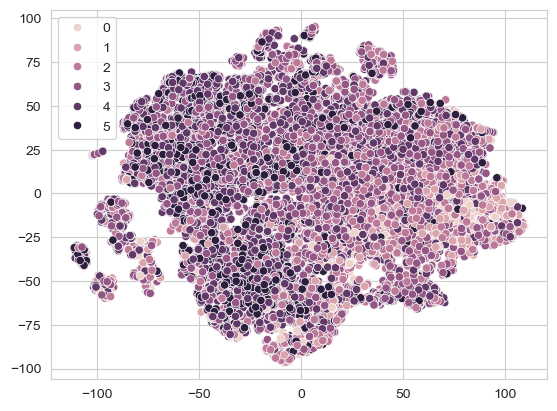

In [45]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y.values)

meh

# Models

In [138]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import make_scorer
import optuna
X = df.drop(columns='target')
X_scaled = StandardScaler().fit_transform(X)
y = df.target - 1

In [139]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def accuracy(true: np.ndarray, pred: np.ndarray):
    return accuracy_score(true, pred.round().clip(0, 5))

def f1(true: np.ndarray, pred: np.ndarray):
    return f1_score(true, pred.round().clip(0, 5), average='macro')

def f1_weighted(true: np.ndarray, pred: np.ndarray):
    return f1_score(true, pred.round().clip(0, 5), average='weighted')

In [140]:
regression_results = pd.DataFrame(
    {
        'model': [],
        'accuracy': [],
        'f1 macro': [],
        'f1 weighted': [],
    }
)

classification_results = pd.DataFrame(
    {
        'model': [],
        'accuracy': [],
        'f1 macro': [],
        'f1 weighted': [],
        'roc auc': [],
    }
)

In [141]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_regression(model, X, y, model_name=None):
    scores = cross_validate(model, X, y, cv=5, scoring={'accuracy': make_scorer(accuracy), 'f1': make_scorer(f1), 'f1_weighted': make_scorer(f1_weighted)}, return_train_score=True, n_jobs=-1)
    test_demo(model, X, y)
    print('Train accuracy:', scores['train_accuracy'].mean())
    print('Test accuracy:', scores['test_accuracy'].mean())
    print('Train F1:', scores['train_f1'].mean())
    print('Test F1:', scores['test_f1'].mean())
    print('Train F1 weighted:', scores['train_f1_weighted'].mean())
    print('Test F1 weighted:', scores['test_f1_weighted'].mean())
    return {
        'model': model_name,
        'accuracy': scores['test_accuracy'].mean(),
        'f1 macro': scores['test_f1'].mean(),
        'f1 weighted': scores['test_f1_weighted'].mean(),
    }

def test_classification(model, X, y, model_name=None):
    scores = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'f1_macro', 'f1_weighted', 'roc_auc_ovr'], return_train_score=True, n_jobs=-1)
    test_demo(model, X, y)
    print('Train accuracy:', scores['train_accuracy'].mean())
    print('Test accuracy:', scores['test_accuracy'].mean())
    print('Train F1 macro:', scores['train_f1_macro'].mean())
    print('Test F1 macro:', scores['test_f1_macro'].mean())
    print('Train F1 weighted:', scores['train_f1_weighted'].mean())
    print('Test F1 weighted:', scores['test_f1_weighted'].mean())
    print('Train roc_auc:', scores['train_roc_auc_ovr'].mean())
    print('Test roc_auc:', scores['test_roc_auc_ovr'].mean())
    return {
        'model': model_name,
        'accuracy': scores['test_accuracy'].mean(),
        'f1 macro': scores['test_f1_macro'].mean(),
        'f1 weighted': scores['test_f1_weighted'].mean(),
        'roc auc': scores['test_roc_auc_ovr'].mean(),
    }

def test_demo(model, X, y):
    y_pred = cross_val_predict(model, X, y, cv=5, n_jobs=-1).round().clip(0, 5)
    # print(y_pred)
    report = classification_report(y, y_pred)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, y_pred))
    conf_disp.plot()
    print(report)

## Linear regression
### Optimizing model's parameters

In [142]:
from sklearn.linear_model import ElasticNet
def objective(trial):
    return cross_val_score(ElasticNet(alpha=10 ** trial.suggest_float('r', -15, -1), l1_ratio=trial.suggest_float('l1_ratio', 0, 1)), X_scaled, y, cv=3, scoring=make_scorer(f1), n_jobs=-1).mean()

In [143]:
study = optuna.create_study(direction='maximize')

[I 2023-12-29 08:45:30,197] A new study created in memory with name: no-name-d09eeedb-59d7-40aa-a89f-abbc91e2a878


In [144]:
# study.optimize(objective, 150, n_jobs=2)

### Validation curves

In [145]:
# results = study.trials_dataframe()
# results = results[['params_r', 'params_l1_ratio', 'value']]
# results.to_csv('res1.csv', index=0)

<Axes: xlabel='params_l1_ratio'>

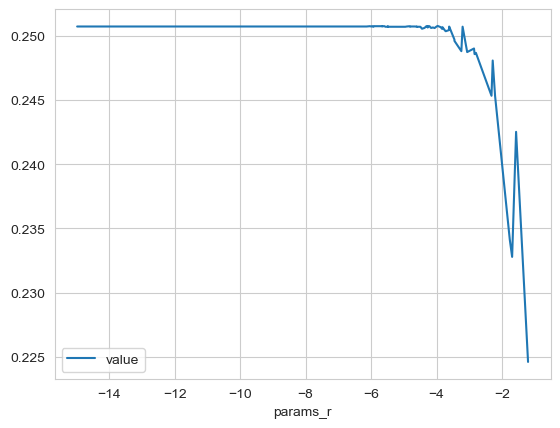

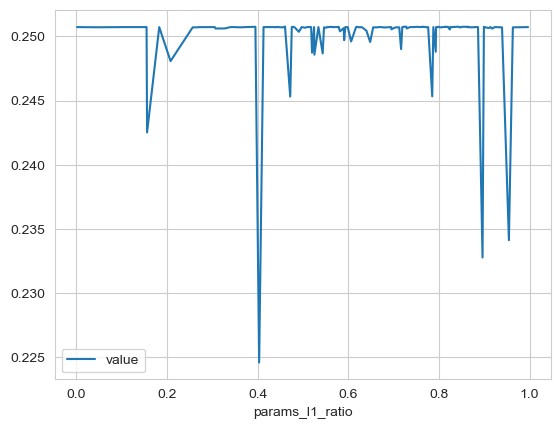

In [146]:
results = pd.read_csv('res1.csv')
results.sort_values('params_r').plot('params_r', 'value')
results.sort_values('params_l1_ratio').plot('params_l1_ratio', 'value')

### Summary


In [147]:
# study.best_params

         coef                    feature    cfsabs
0    0.364087      calculation_method_id  0.364087
27   0.287446                   lifetime  0.287446
151 -0.192614      raion_post_work_Одеса  0.192614
158  0.177051       city_post_work_Одеса  0.177051
11  -0.176670                   lat_home  0.176670
102 -0.166223         oblast_post_home_0  0.166223
55  -0.164865             intagram_count  0.164865
1   -0.151158    calls_count_in_weekdays  0.151158
171 -0.138950  software_os_vendor_Google  0.138950
122  0.121851      raion_post_home_Одеса  0.121851
3.226


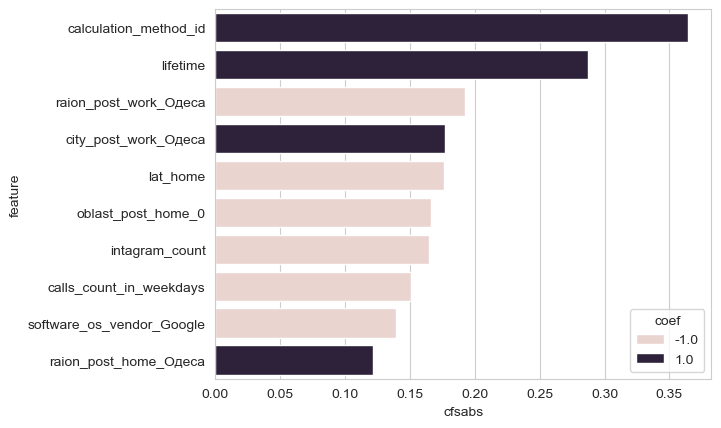

In [148]:
best_model = ElasticNet(alpha=10 ** -3.4830616118731865, l1_ratio=0.007996122903324281)
best_model.fit(X_scaled, y)
cfs = pd.DataFrame({'coef':best_model.coef_, 'feature':X.columns})
cfs['cfsabs'] = np.abs(cfs.coef)
cfs = cfs.sort_values('cfsabs', ascending=False).head(10)
print(cfs)
# plt.barh((cfs).sort_values('cfsabs', ascending=True).tail(10).feature, (cfs).sort_values('cfsabs', ascending=True).tail(10).coef, hue)
sns.barplot(x=cfs.cfsabs, y=cfs.feature, hue=np.sign(cfs.coef), orient='h', dodge=False)
# plt.xticks(rotation=30, ha='right')
print(best_model.intercept_)

              precision    recall  f1-score   support

           0       0.19      0.02      0.03       548
           1       0.49      0.11      0.18      1076
           2       0.38      0.27      0.31      4047
           3       0.36      0.59      0.45      6020
           4       0.40      0.51      0.44      6029
           5       0.46      0.05      0.08      3280

    accuracy                           0.38     21000
   macro avg       0.38      0.26      0.25     21000
weighted avg       0.39      0.38      0.34     21000

Train accuracy: 0.38089285714285714
Test accuracy: 0.378
Train F1: 0.25213118467747997
Test F1: 0.24973875662778505
Train F1 weighted: 0.3415867933778739
Test F1 weighted: 0.33863631594540144


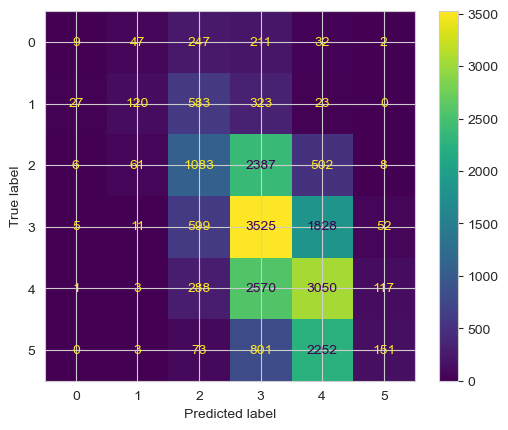

In [149]:
regression_results = regression_results.append(test_regression(best_model, X_scaled, y, 'linreg'), ignore_index=True)

Regularization works fine, no overfitting here, but results are not satisfying.\
Matrix is not impressive.

## Random Forest Classifier
### Optimizing model's parameters

In [150]:
from sklearn.ensemble import RandomForestClassifier
def objective(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_features': trial.suggest_int('max_features', 5, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 40),
    }
    return cross_val_score(RandomForestClassifier(**rf_params), X_scaled, y, cv=3, scoring=make_scorer(f1), n_jobs=-1).mean()

In [151]:
study = optuna.create_study(direction='maximize')

[I 2023-12-29 08:45:55,669] A new study created in memory with name: no-name-e2608754-f144-4000-878a-bfab93046af0


In [152]:
# study.optimize(objective, 150, n_jobs=-1)

### Validation curves

In [153]:
# results = study.trials_dataframe()
# results = results[['params_n_estimators', 'params_max_features', 'params_max_depth', 'value']]
# results.to_csv('res2.csv', index=0)

<Axes: xlabel='params_max_depth'>

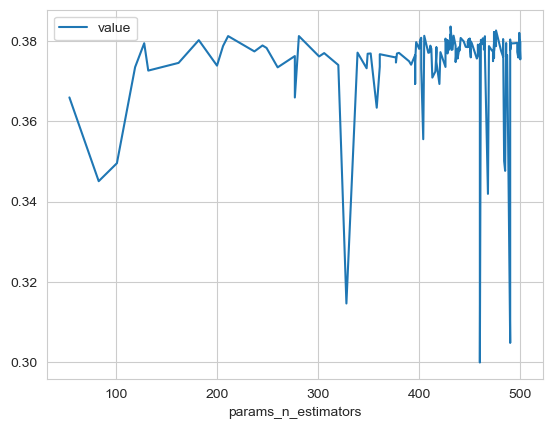

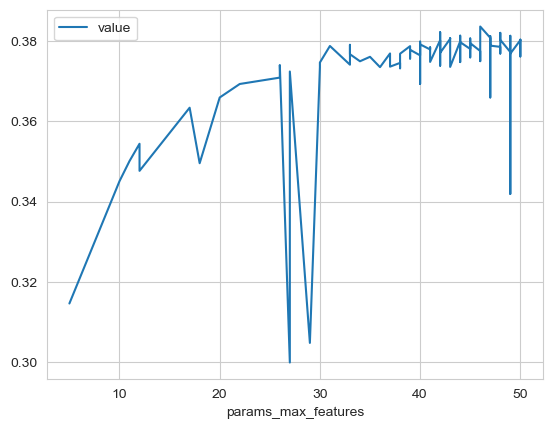

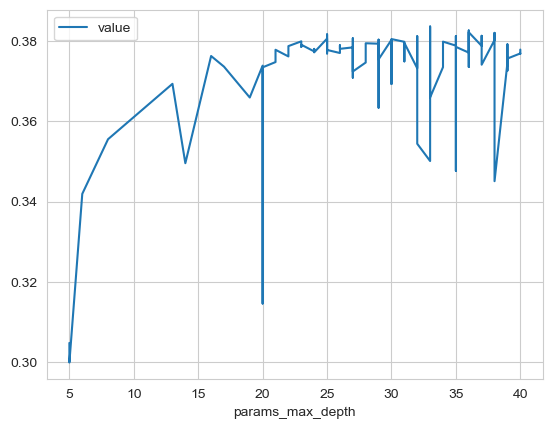

In [154]:
results = pd.read_csv('res2.csv')
results.sort_values('params_n_estimators').plot('params_n_estimators', 'value')
results.sort_values('params_max_features').plot('params_max_features', 'value')
results.sort_values('params_max_depth').plot('params_max_depth', 'value')

### Summary


In [155]:
# study.best_params

In [156]:
best_model = RandomForestClassifier(n_estimators=431, max_features=46, max_depth=33, n_jobs=-1)
best_model.fit(X, y)
cfs = pd.DataFrame({'importance':best_model.feature_importances_, 'feature':X.columns})
print((cfs).sort_values('importance', ascending=False).head(10))


    importance                      feature
27    0.062456                     lifetime
21    0.039472                     avg_arpu
1     0.028072      calls_count_in_weekdays
2     0.027155   calls_duration_in_weekdays
4     0.026752  calls_duration_out_weekdays
6     0.026675   calls_duration_in_weekends
3     0.026387     calls_count_out_weekdays
8     0.024939  calls_duration_out_weekends
54    0.024412             instagram_volume
28    0.023008          how_long_same_model


Some of the features intersect with linear model.

              precision    recall  f1-score   support

           0       0.44      0.08      0.13       548
           1       0.50      0.32      0.39      1076
           2       0.43      0.40      0.42      4047
           3       0.41      0.45      0.43      6020
           4       0.42      0.50      0.45      6029
           5       0.52      0.41      0.46      3280

    accuracy                           0.43     21000
   macro avg       0.45      0.36      0.38     21000
weighted avg       0.44      0.43      0.43     21000

Train accuracy: 1.0
Test accuracy: 0.43223809523809525
Train F1 macro: 1.0
Test F1 macro: 0.3799339492783129
Train F1 weighted: 1.0
Test F1 weighted: 0.42834137517830795
Train roc_auc: 1.0
Test roc_auc: 0.7929312737793761


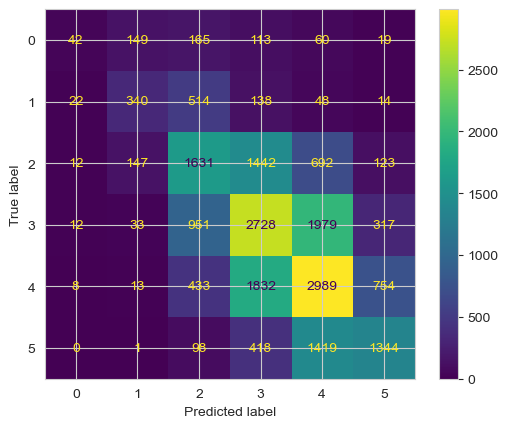

In [157]:
classification_results = classification_results.append(test_classification(best_model, X, y, 'RF classifier'), ignore_index=True)

We can clearly see significant overfitting. Test accuracy score is better. Though, still unsatisfactory.\
But matrix looks better.

## Random Forest Regressor
### Optimizing model's parameters

In [158]:
from sklearn.ensemble import RandomForestRegressor
def objective(trial):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_features': trial.suggest_int('max_features', 5, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    }
    return cross_val_score(RandomForestRegressor(**rf_params), X, y, cv=3, scoring=make_scorer(f1), n_jobs=-1).mean()

In [159]:
study = optuna.create_study(direction='maximize')

[I 2023-12-29 08:47:00,047] A new study created in memory with name: no-name-b6b84a90-0287-4c8e-9c65-dadd9d8870b5


In [160]:
# study.optimize(objective, 30, n_jobs=-1)

### Validation curves

In [161]:
# results = study.trials_dataframe()
# results = results[['params_n_estimators', 'params_max_features', 'params_max_depth', 'params_min_samples_split', 'params_min_samples_leaf', 'value']]
# results.to_csv('res3.csv', index=0)

<Axes: xlabel='params_min_samples_leaf'>

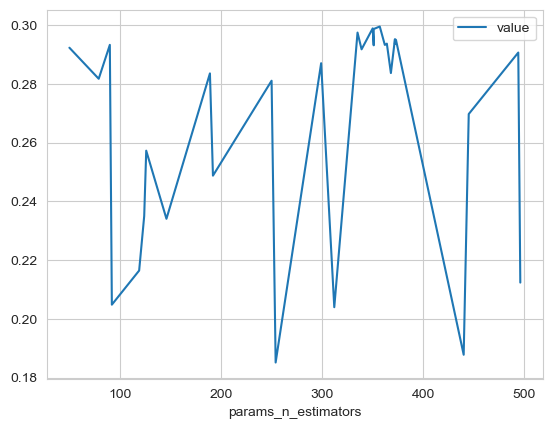

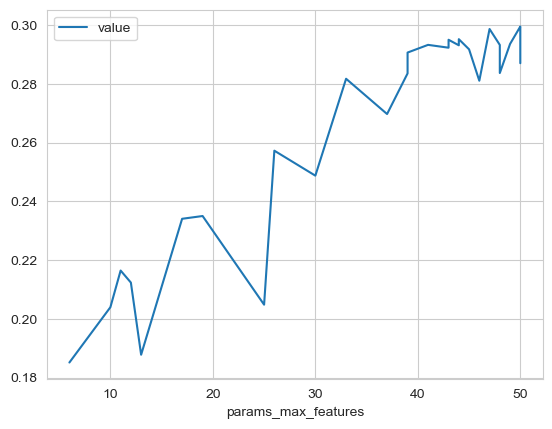

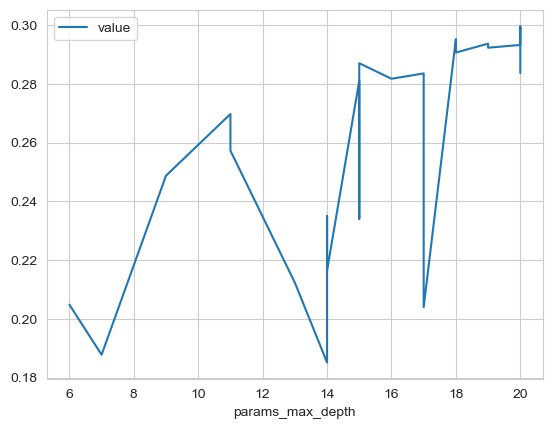

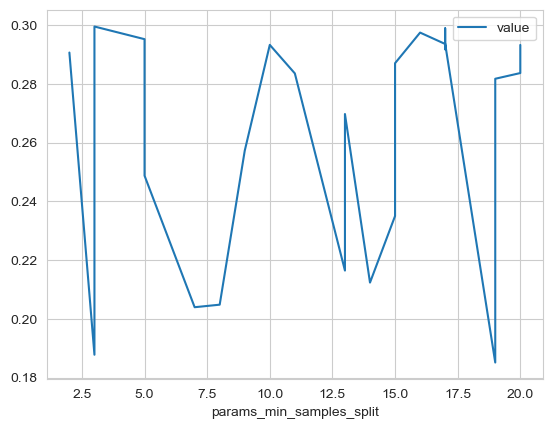

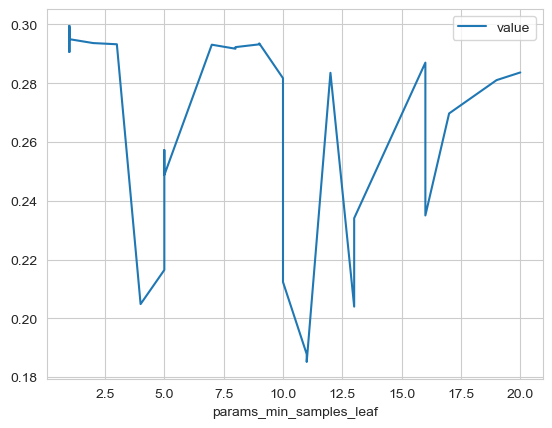

In [162]:
results = pd.read_csv('res3.csv')
results.sort_values('params_n_estimators').plot('params_n_estimators', 'value')
results.sort_values('params_max_features').plot('params_max_features', 'value')
results.sort_values('params_max_depth').plot('params_max_depth', 'value')
results.sort_values('params_min_samples_split').plot('params_min_samples_split', 'value')
results.sort_values('params_min_samples_leaf').plot('params_min_samples_leaf', 'value')

### Summary

In [163]:
# study.best_params

In [164]:
best_model = RandomForestRegressor(n_estimators=357, max_features=50, max_depth=20, min_samples_split=3, min_samples_leaf=1, n_jobs=-1)
best_model.fit(X, y)
cfs = pd.DataFrame({'importance':best_model.feature_importances_, 'feature':X.columns})
print((cfs).sort_values('importance', ascending=False).head(10))


    importance                      feature
27    0.103931                     lifetime
0     0.093812        calculation_method_id
54    0.069958             instagram_volume
55    0.040955               intagram_count
9     0.032352         data_volume_weekdays
21    0.030604                     avg_arpu
10    0.026063         data_volume_weekends
4     0.021226  calls_duration_out_weekdays
1     0.021191      calls_count_in_weekdays
2     0.019897   calls_duration_in_weekdays


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       548
           1       0.51      0.28      0.36      1076
           2       0.43      0.29      0.35      4047
           3       0.39      0.62      0.48      6020
           4       0.41      0.52      0.46      6029
           5       0.72      0.10      0.18      3280

    accuracy                           0.41     21000
   macro avg       0.41      0.30      0.30     21000
weighted avg       0.45      0.41      0.38     21000

Train accuracy: 0.7738690476190476
Test accuracy: 0.4127619047619048
Train F1: 0.6797066468732195
Test F1: 0.3022789002410104
Train F1 weighted: 0.7625321235380783
Test F1 weighted: 0.3808936574144658


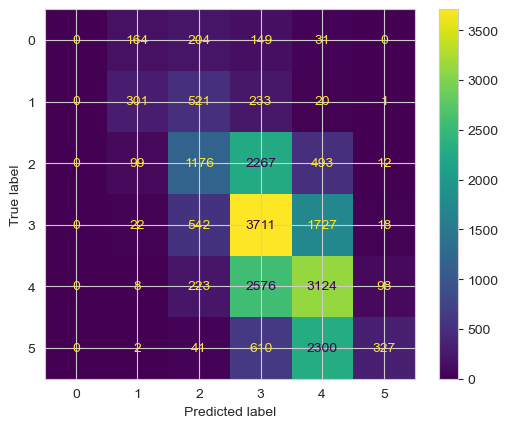

In [165]:
regression_results = regression_results.append(test_regression(best_model, X, y, 'RF regressor'), ignore_index=True)

As expected, less overfitting with stricter tree depth and tuning of splitting parameters. But results aren't better.

## MLP classifier
### Optimizing model's parameters

In [166]:
from scipy.stats import randint
from sklearn.neural_network import MLPClassifier

def objective(trial):
    n_max = 5
    params = {
        # 'hidden_layer_sizes' : tuple(randint.rvs(10, 100, size=randint.rvs(1, 5))),
        'n_layers': trial.suggest_int('n_layers', 1, n_max),
        'layers': [trial.suggest_int(f'{i}_layer', 1, 50) for i in range(n_max)],
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'learing_rate': 10 ** trial.suggest_float('lr', -5, -1),
        'alpha': 10 ** trial.suggest_float('r', -10, -1),
    }
    n_layers = trial.suggest_int('n_layers', 1, n_max)
    layers = [trial.suggest_int(f'{i}_layer', 1, 50) for i in range(n_max)]
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    lr = 10 ** trial.suggest_float('lr', -5, -1)
    alpha = 10 ** trial.suggest_float('r', -10, -1)
    return cross_val_score(MLPClassifier(layers[:n_layers], activation, alpha=alpha, learning_rate_init=lr, random_state=1), X_scaled, y, cv=3, scoring='f1_macro', n_jobs=-1).mean()

In [167]:
study = optuna.create_study(direction='maximize')

[I 2023-12-29 08:47:55,732] A new study created in memory with name: no-name-f0a10d19-a1d3-4830-8093-6d50da399381


In [168]:
# study.optimize(objective, 30, n_jobs=-1)

### Validation curves

In [169]:
# results = study.trials_dataframe()
# results = results[['params_n_layers', 'params_activation', 'params_lr', 'params_r', 'value']]
# results.to_csv('res4.csv', index=0)

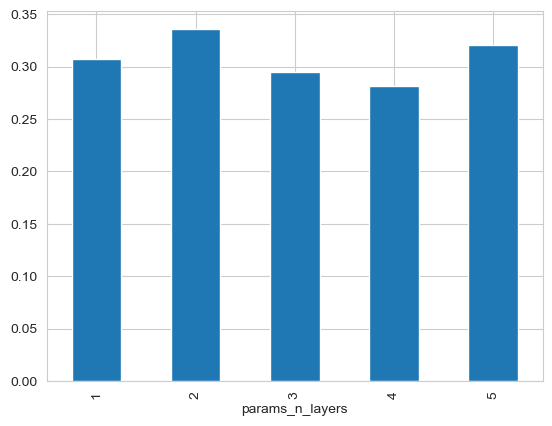

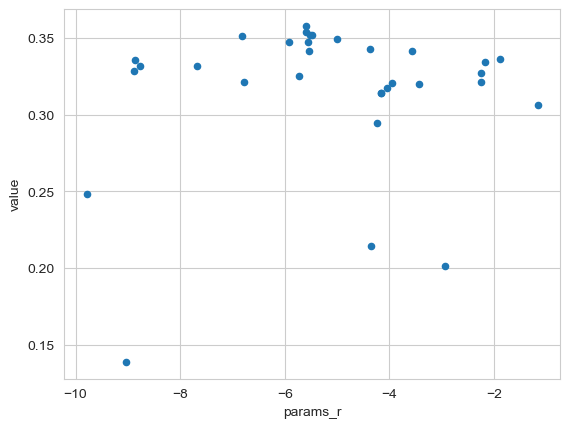

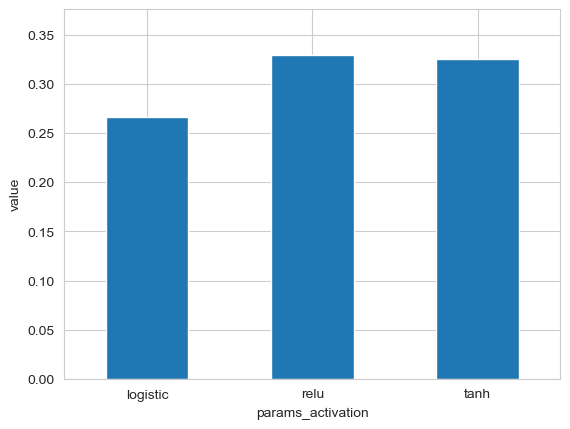

In [170]:
results = pd.read_csv('res4.csv')
results.groupby('params_n_layers')['value'].mean().plot(kind='bar')
results.sort_values('params_r').plot('params_r', 'value', kind='scatter')
results.sort_values('params_lr').plot('params_lr', 'value', kind='scatter')
a = results.groupby('params_activation')['value'].mean().plot(kind='bar', rot=0)

### Summary

In [171]:
# study.best_params

In [172]:
{'n_layers': 2,
 '0_layer': 8,
 '1_layer': 17,
 '2_layer': 14,
 '3_layer': 42,
 '4_layer': 36,
 'activation': 'relu',
 'lr': -2.6289527394151126,
 'r': -5.583955479132559}

best_model = MLPClassifier([8, 17], learning_rate_init=10 ** -2.6289527394151126, alpha=10 ** -5.583955479132559)
best_model.fit(X_scaled, y)

MLPClassifier(alpha=2.60642072853552e-06, hidden_layer_sizes=[8, 17],
              learning_rate_init=0.0023498885253720216)

              precision    recall  f1-score   support

           0       0.22      0.11      0.15       548
           1       0.40      0.32      0.36      1076
           2       0.40      0.38      0.39      4047
           3       0.40      0.38      0.39      6020
           4       0.40      0.50      0.45      6029
           5       0.46      0.40      0.43      3280

    accuracy                           0.41     21000
   macro avg       0.38      0.35      0.36     21000
weighted avg       0.41      0.41      0.40     21000

Train accuracy: 0.4649523809523809
Test accuracy: 0.40647619047619044
Train F1 macro: 0.4378287771833736
Test F1 macro: 0.356542891910551
Train F1 weighted: 0.4621881695447222
Test F1 weighted: 0.40172329949627805
Train roc_auc: 0.8182480779379201
Test roc_auc: 0.7651374979001282


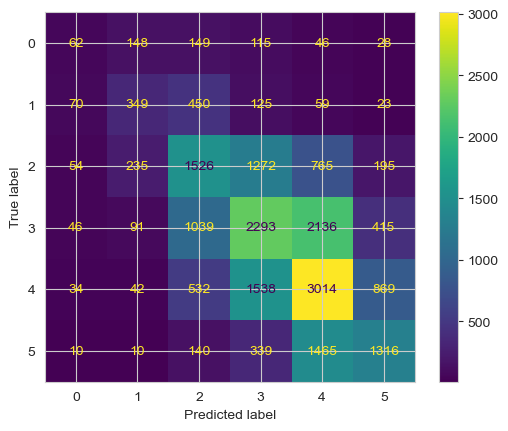

In [173]:
classification_results = classification_results.append(test_classification(best_model, X_scaled, y, 'MLP classifier'), ignore_index=True)

Results are still not great, model is overfitted.

## LGBM Regressor
### Optimizing model's parameters

In [174]:
import lightgbm as lgbm

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'n_estimators':trial.suggest_int('n_estimators', 1, 500),
        'learning_rate': 10 ** trial.suggest_float('learning_rate', -4, -1),
        'lambda_l1': 10 ** trial.suggest_float('lambda_l1', -7, -1),
        'lambda_l2': 10 ** trial.suggest_float('lambda_l2', -7, -1),
        'subsample': trial.suggest_float('subsample', 0, 1),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10)
    }
    return cross_val_score(lgbm.LGBMRegressor(**params), X, y, cv=4, scoring=make_scorer(f1), n_jobs=-1).mean()

In [175]:
study = optuna.create_study(direction='maximize')

[I 2023-12-29 08:48:17,952] A new study created in memory with name: no-name-257cc8cd-bb2d-43d3-a66b-42bc133a395b


In [176]:
# study.optimize(objective, 300, n_jobs=10)

### Validation curves

In [177]:
# results = study.trials_dataframe()
# results = results[['params_num_leaves', 'params_min_data_in_leaf', 'params_max_depth', 'params_n_estimators', 'params_learning_rate', 'params_lambda_l1', 'params_lambda_l2', 'params_subsample', 'params_subsample_freq', 'value']]
# results.to_csv('res5.csv', index=0)

<Axes: xlabel='params_subsample_freq'>

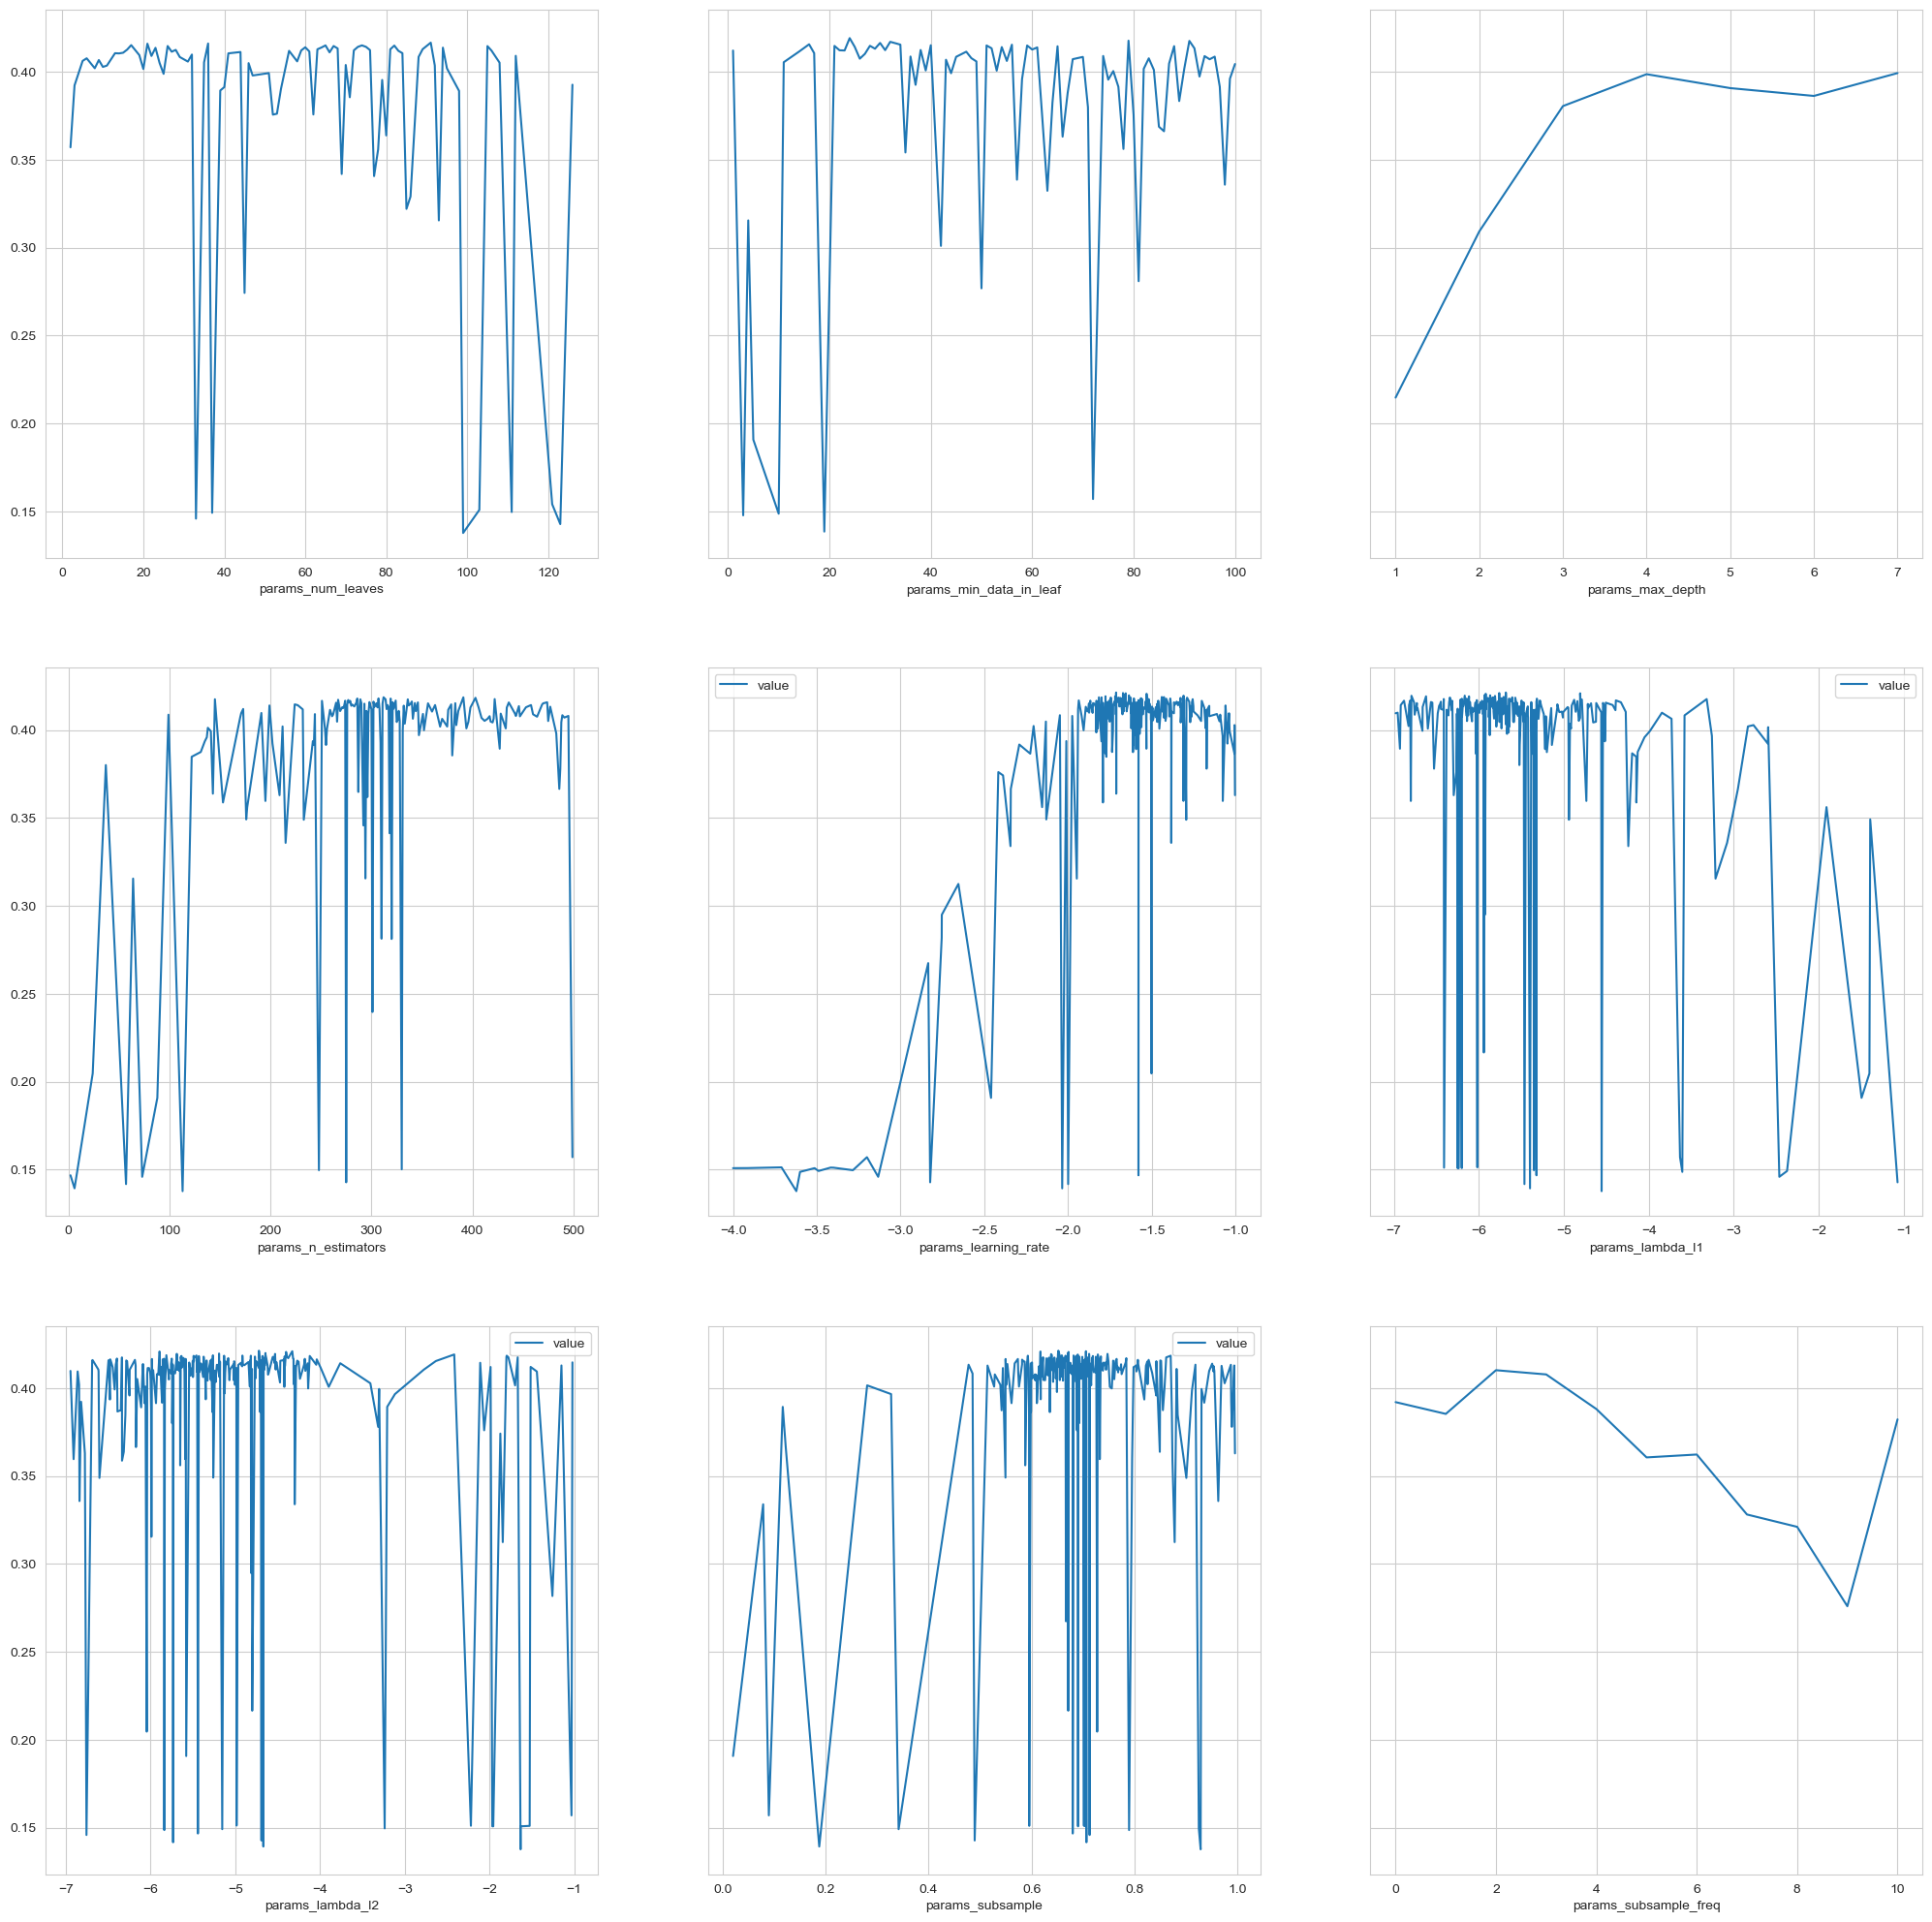

In [178]:
results = pd.read_csv('res5.csv')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25), sharey=True)
results.groupby('params_num_leaves')['value'].mean().plot(ax=axes[0, 0])
results.groupby('params_min_data_in_leaf')['value'].mean().plot(ax=axes[0, 1])
results.groupby('params_max_depth')['value'].mean().plot(ax=axes[0, 2])
results.groupby('params_n_estimators')['value'].mean().plot(ax=axes[1, 0])
results.sort_values('params_learning_rate').plot('params_learning_rate', 'value', ax=axes[1, 1])
results.sort_values('params_lambda_l1').plot('params_lambda_l1', 'value', ax=axes[1, 2])
results.sort_values('params_lambda_l2').plot('params_lambda_l2', 'value', ax=axes[2, 0])
results.sort_values('params_subsample').plot('params_subsample', 'value', ax=axes[2, 1])
results.groupby('params_subsample_freq')['value'].mean().plot(ax=axes[2, 2])

### Summary

In [179]:
# study.best_params

In [180]:
best_params = {'num_leaves': 100, 'min_data_in_leaf': 89, 'max_depth': 7, 'n_estimators': 433,
               'learning_rate': 10 ** -1.1604469590212916, 'lambda_l1': 10 ** -6.357379014986101, 'lambda_l2': 10 ** -1.024535716123458,
               'subsample': 0.776124081941854, 'subsample_freq': 10}
best_model = lgbm.LGBMRegressor(**best_params)
best_model.fit(X, y)


LGBMRegressor(lambda_l1=4.3915818853887565e-07, lambda_l2=0.09450706671873915,
              learning_rate=0.06911193315994113, max_depth=7,
              min_data_in_leaf=89, n_estimators=433, num_leaves=100,
              subsample=0.776124081941854, subsample_freq=10)

              precision    recall  f1-score   support

           0       0.44      0.04      0.07       548
           1       0.46      0.31      0.37      1076
           2       0.42      0.31      0.36      4047
           3       0.39      0.57      0.46      6020
           4       0.41      0.52      0.46      6029
           5       0.67      0.18      0.28      3280

    accuracy                           0.42     21000
   macro avg       0.47      0.32      0.33     21000
weighted avg       0.45      0.42      0.40     21000

Train accuracy: 0.5383690476190476
Test accuracy: 0.4167142857142857
Train F1: 0.46069603435417983
Test F1: 0.3334567372893079
Train F1 weighted: 0.5220703880286054
Test F1 weighted: 0.39811288444511617


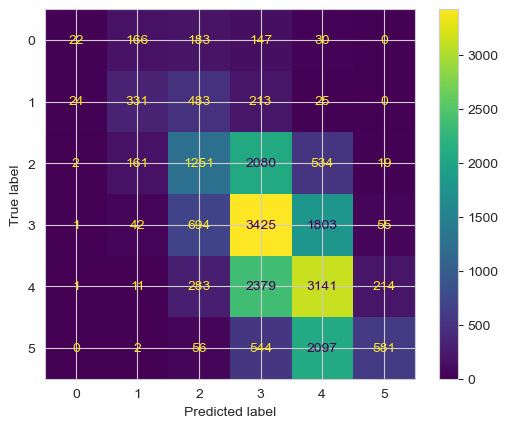

In [181]:
regression_results = regression_results.append(test_regression(best_model, X, y, 'LGBM regressor'), ignore_index=True)

We can clearly see overfitting. Results are still unsatisfactory.\
Matrix is quite good.

## LGBM Classifier
### Optimizing model's parameters

In [182]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'max_depth': trial.suggest_int('max_depth', 1, 7),
        'n_estimators':trial.suggest_int('n_estimators', 1, 500),
        'learning_rate': 10 ** trial.suggest_float('learning_rate', -4, -1),
        'lambda_l1': 10 ** trial.suggest_float('lambda_l1', -7, -1),
        'lambda_l2': 10 ** trial.suggest_float('lambda_l2', -7, -1),
        'subsample': trial.suggest_float('subsample', 0, 1),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10)
    }
    return cross_val_score(lgbm.LGBMClassifier(**params), X, y, cv=4, scoring='f1_macro', n_jobs=-1).mean()

In [183]:
study = optuna.create_study(direction='maximize')

[I 2023-12-29 08:48:25,316] A new study created in memory with name: no-name-d914531e-9521-472e-93af-df11275de4a7


In [184]:
# study.optimize(objective, 300, n_jobs=10)

### Validation curves

In [185]:
# results = study.trials_dataframe()
# results = results[['params_num_leaves', 'params_min_data_in_leaf', 'params_max_depth', 'params_n_estimators', 'params_learning_rate', 'params_lambda_l1', 'params_lambda_l2', 'params_subsample', 'params_subsample_freq', 'value']]
# results.to_csv('res5.csv', index=0)

<Axes: xlabel='params_subsample_freq'>

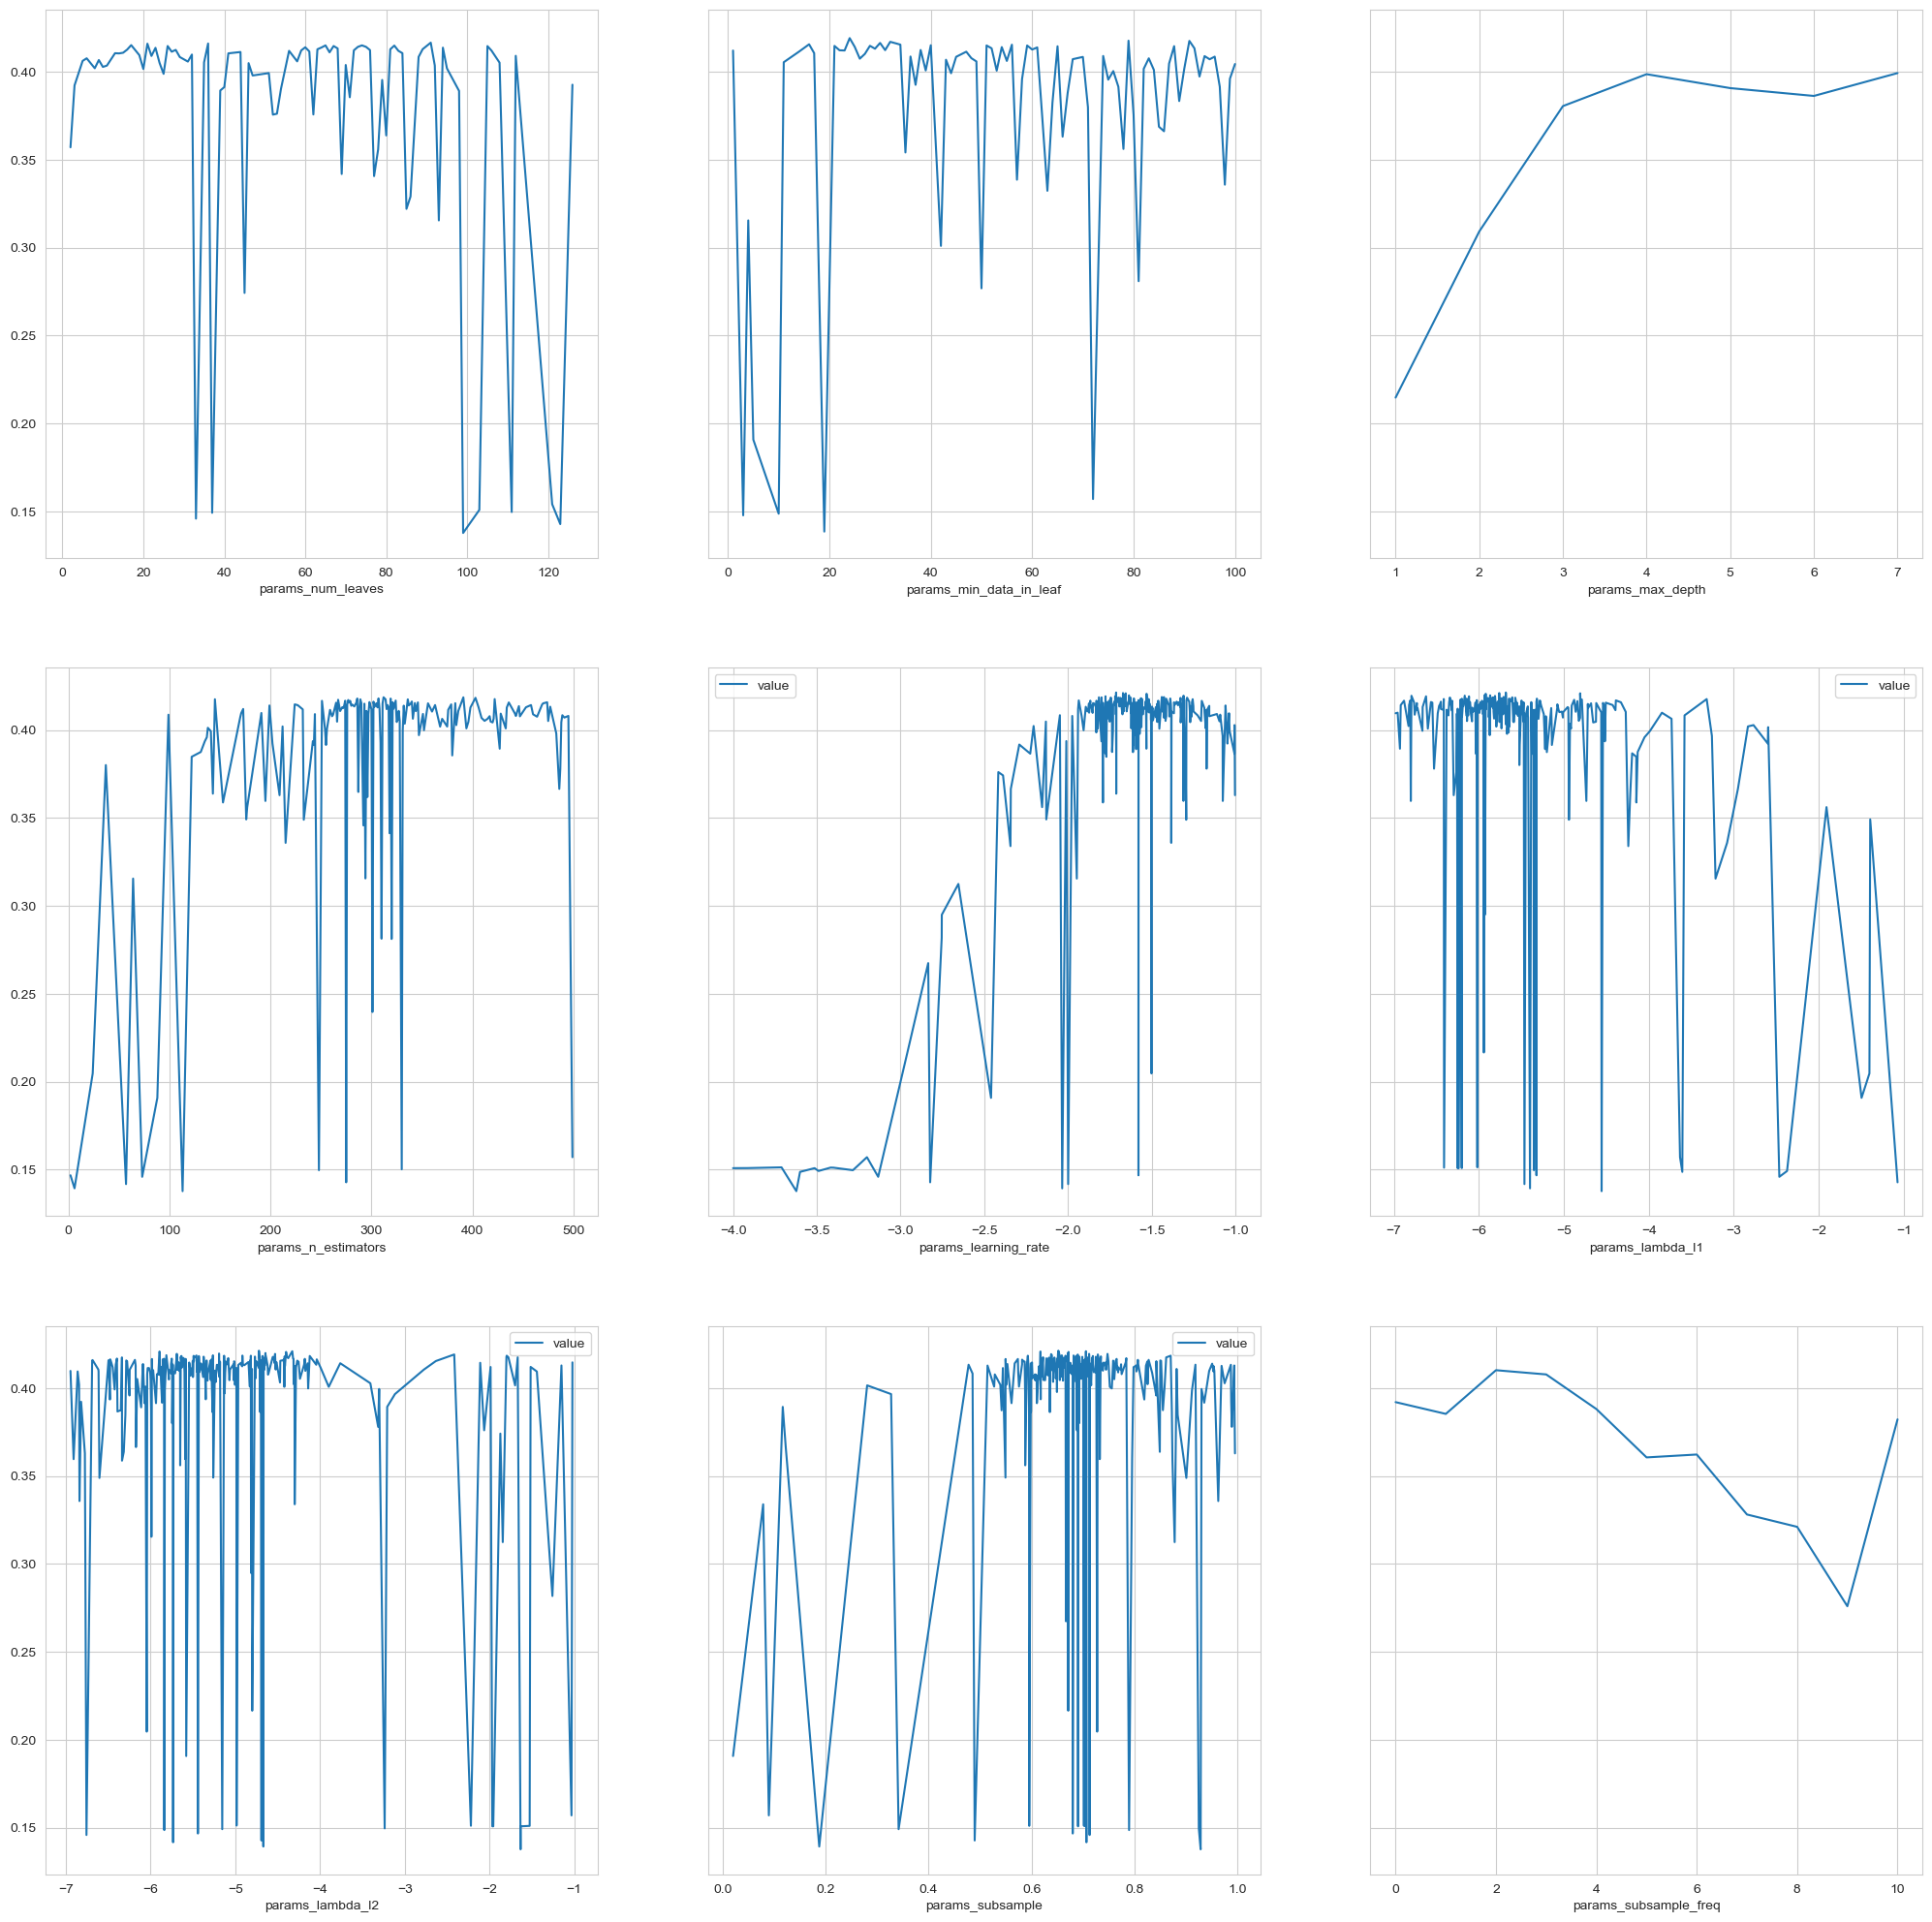

In [186]:
results = pd.read_csv('res5.csv')
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25), sharey=True)
results.groupby('params_num_leaves')['value'].mean().plot(ax=axes[0, 0])
results.groupby('params_min_data_in_leaf')['value'].mean().plot(ax=axes[0, 1])
results.groupby('params_max_depth')['value'].mean().plot(ax=axes[0, 2])
results.groupby('params_n_estimators')['value'].mean().plot(ax=axes[1, 0])
results.sort_values('params_learning_rate').plot('params_learning_rate', 'value', ax=axes[1, 1])
results.sort_values('params_lambda_l1').plot('params_lambda_l1', 'value', ax=axes[1, 2])
results.sort_values('params_lambda_l2').plot('params_lambda_l2', 'value', ax=axes[2, 0])
results.sort_values('params_subsample').plot('params_subsample', 'value', ax=axes[2, 1])
results.groupby('params_subsample_freq')['value'].mean().plot(ax=axes[2, 2])

### Summary

In [187]:
# study.best_params

In [188]:
best_params = {'num_leaves': 69,
               'min_data_in_leaf': 54,
               'max_depth': 7,
               'n_estimators': 312,
               'learning_rate': 10 ** -1.7137708087266987,
               'lambda_l1': 10 ** -5.682342283141946,
               'lambda_l2': 10 ** -4.721341037751649,
               'subsample': 0.6521485889751121,
               'subsample_freq': 2}
best_model = lgbm.LGBMClassifier(**best_params)
best_model.fit(X, y)


LGBMClassifier(lambda_l1=2.078058248891184e-06,
               lambda_l2=1.8995860091354864e-05,
               learning_rate=0.019329881483870114, max_depth=7,
               min_data_in_leaf=54, n_estimators=312, num_leaves=69,
               subsample=0.6521485889751121, subsample_freq=2)

              precision    recall  f1-score   support

           0       0.45      0.20      0.28       548
           1       0.49      0.38      0.43      1076
           2       0.44      0.41      0.43      4047
           3       0.43      0.42      0.42      6020
           4       0.42      0.51      0.46      6029
           5       0.53      0.46      0.49      3280

    accuracy                           0.44     21000
   macro avg       0.46      0.40      0.42     21000
weighted avg       0.45      0.44      0.44     21000

Train accuracy: 0.687142857142857
Test accuracy: 0.4441428571428571
Train F1 macro: 0.7245254787262181
Test F1 macro: 0.4188169371880435
Train F1 weighted: 0.6883235268297494
Test F1 weighted: 0.44253501118223665
Train roc_auc: 0.927395690039338
Test roc_auc: 0.8022284597246407


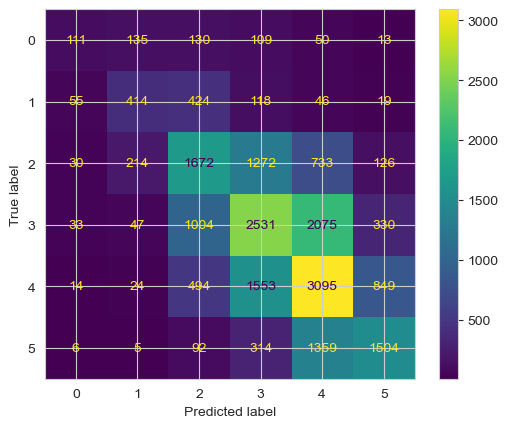

In [189]:
classification_results = classification_results.append(test_classification(best_model, X, y, 'LGBM classifier'), ignore_index=True)

Our best result so far.\
Matrix is also quite nice.

In [190]:
classification_results.to_csv('res_classification.csv', index=False)
regression_results.to_csv('res_regression.csv', index=False)

In [191]:
classification_results = pd.read_csv('res_classification.csv')
regression_results = pd.read_csv('res_regression.csv')

In [192]:
classification_results

,model,accuracy,f1 macro,f1 weighted,roc auc
0,RF classifier,0.432238,0.379934,0.428341,0.792931
1,MLP classifier,0.406476,0.356543,0.401723,0.765137
2,LGBM classifier,0.444143,0.418817,0.442535,0.802228


In [193]:
regression_results

,model,accuracy,f1 macro,f1 weighted
0,linreg,0.378000,0.249739,0.338636
1,RF regressor,0.412762,0.302279,0.380894
2,LGBM regressor,0.416714,0.333457,0.398113


We can see that classification model generally slightly better than corresponding regression models.\
LGBM classifier appeared to be the best model so far.\
Linear model is not sutable for this dataset.

## Pytorch
**This is not part of the assignment and it is not included in the report, so no comments here**

In [102]:
X.shape

(21000, 181)

In [103]:
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
device = torch.device('cuda')

NN architecture is a couple of stacked residual blocks with tanh activations.

In [104]:
class NN(nn.Module):
    def __init__(self, layers, neurons, learning_rate, l2, dropout_rate=0.5, activation='relu', batch_size=64, epochs=100):
        super(NN, self).__init__()
        self.activation = activation
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.l2 = l2
        self.blocks = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.fc1 = nn.Linear(181, neurons)
        self.bn1 = nn.BatchNorm1d(neurons)
        for i in range(layers):
            self.blocks.append(nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(neurons, neurons),
                nn.BatchNorm1d(neurons),
                nn.Tanh(),
                nn.Dropout(dropout_rate),
                nn.Linear(neurons, neurons)
            ))
            self.bns.append(nn.BatchNorm1d(neurons))

        self.fc2 = nn.Linear(neurons, 6)

    def forward(self, X):
        X = self.bn1(self.fc1(X))
        for block, bn in zip(self.blocks, self.bns):
            res = X
            X = block(X)
            X = bn(X + res)
            X = nn.functional.tanh(X)
        X = nn.functional.softmax(self.fc2(X))
        return X

    def die(self):
        for p in self.parameters():
            del p
        del self
        torch.cuda.empty_cache()

    def fit(self, X, y):
        curve = []
        loader = DataLoader(TensorDataset(X, y), batch_size=self.batch_size, shuffle=False)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.l2)

        for epoch in range(self.epochs):
            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = criterion(outputs, y_batch)
                curve.append(loss.item())
                loss.backward()
                optimizer.step()
            # print(f'Epoch: {epoch}')
        return curve

    def predict(self, X):
        return torch.argmax(self.forward(X), dim=1)

In [108]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.2, random_state=4)
X_train, X_test, y_train, y_test = torch.from_numpy(X_train).float().to(device), torch.from_numpy(X_test).float().to(device), torch.from_numpy(y_train.values).to(device), torch.from_numpy(y_test.values).to(device)

def test_NN(model):
    model.train()
    a = time.time()
    curve = model.fit(X_train, y_train)
    print(time.time() - a)
    model.eval()


    print('Train accuracy', (y_train == model.predict(X_train)).sum() / y_train.shape[0])
    print('Test accuracy', (y_test == model.predict(X_test)).sum() / y_test.shape[0])
    print('Train ROC_AUC', roc_auc_score(y_train.cpu(), model.forward(X_train).cpu().detach().numpy(), multi_class='ovr'))
    print('Test ROC_AUC', roc_auc_score(y_test.cpu(), model.forward(X_test).cpu().detach().numpy(), multi_class='ovr'))

    y_pred = model.predict(X_test).cpu().detach().numpy()
    # print(y_pred)
    sns.heatmap(confusion_matrix(y_test.cpu(), y_pred), annot=True, fmt='')

    model.die()

    plt.figure(figsize=(10, 10))
    plt.plot(curve)

271.24245834350586
Train accuracy tensor(0.4204, device='cuda:0')
Test accuracy tensor(0.3867, device='cuda:0')
Train ROC_AUC 0.7680527118738412
Test ROC_AUC 0.743183333368825


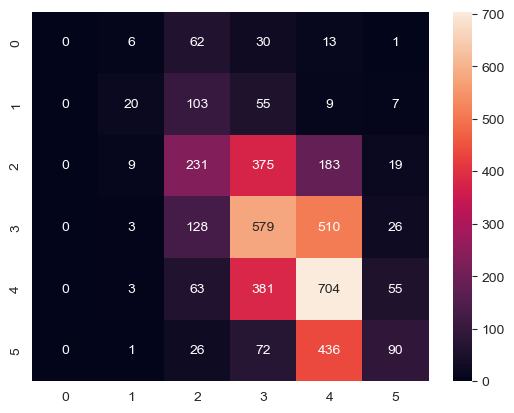

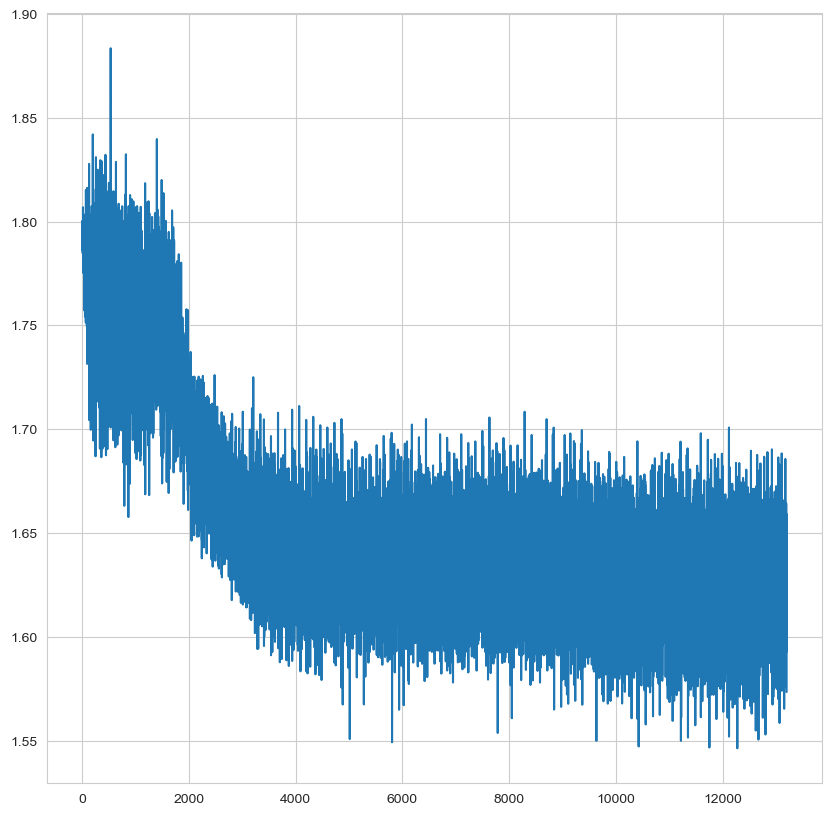

In [109]:
params = {
    'layers': 30,
    'neurons': 600,
    'learning_rate': 5e-4,
    'l2': 5e-3,
    'dropout_rate': 0.75,
    'batch_size': 128,
    'epochs': 100
}

test_NN(NN(**params).to(device))

115.61130952835083
Train accuracy tensor(0.4290, device='cuda:0')
Test accuracy tensor(0.3933, device='cuda:0')
Train ROC_AUC 0.7547822582245054
Test ROC_AUC 0.7300961584686402


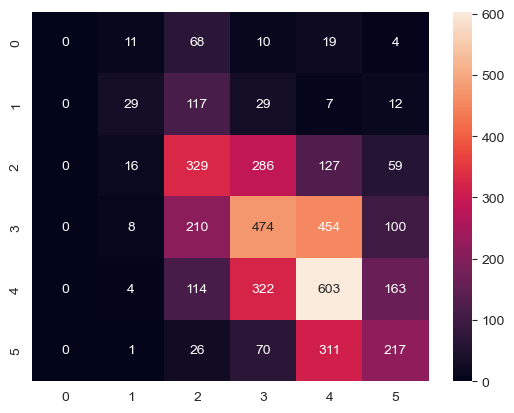

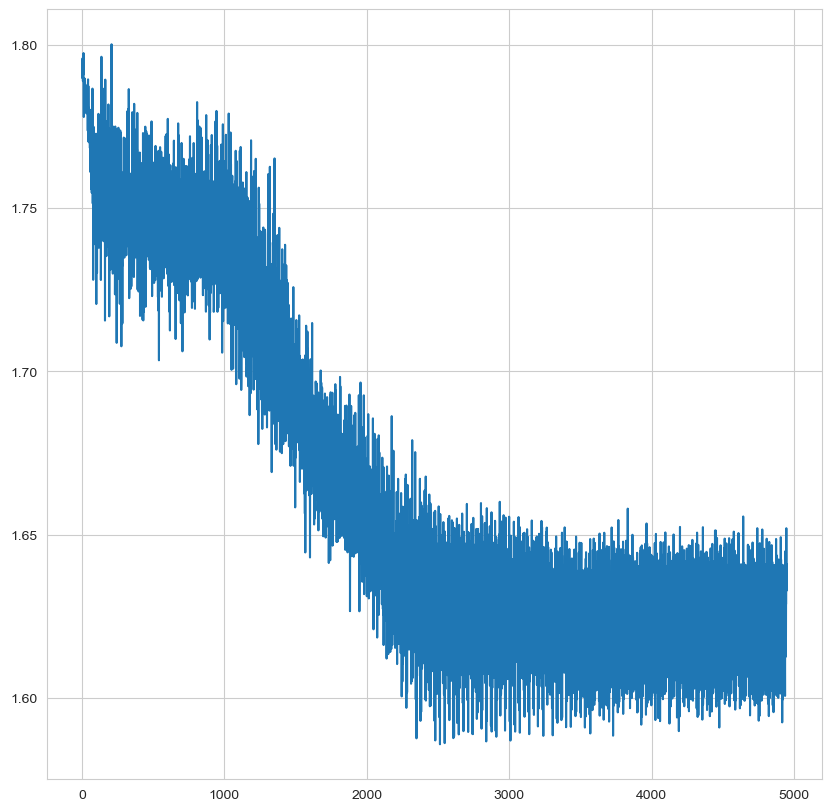

In [110]:
params = {
    'layers': 30,
    'neurons': 800,
    'learning_rate': 5e-4,
    'l2': 5e-3,
    'dropout_rate': 0.75,
    'batch_size': 512,
    'epochs': 150
}

test_NN(NN(**params).to(device))

766.6943383216858
Train accuracy tensor(0.3638, device='cuda:0')
Test accuracy tensor(0.3645, device='cuda:0')
Train ROC_AUC 0.6276735422717966
Test ROC_AUC 0.6211205573144364


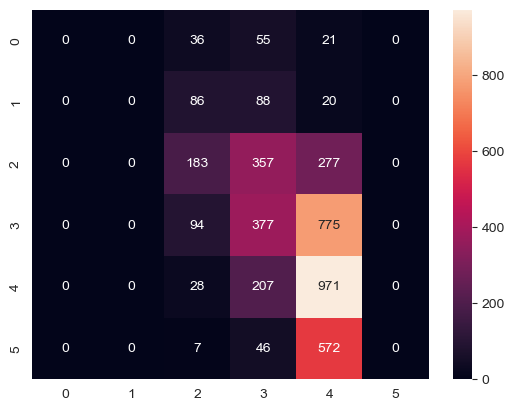

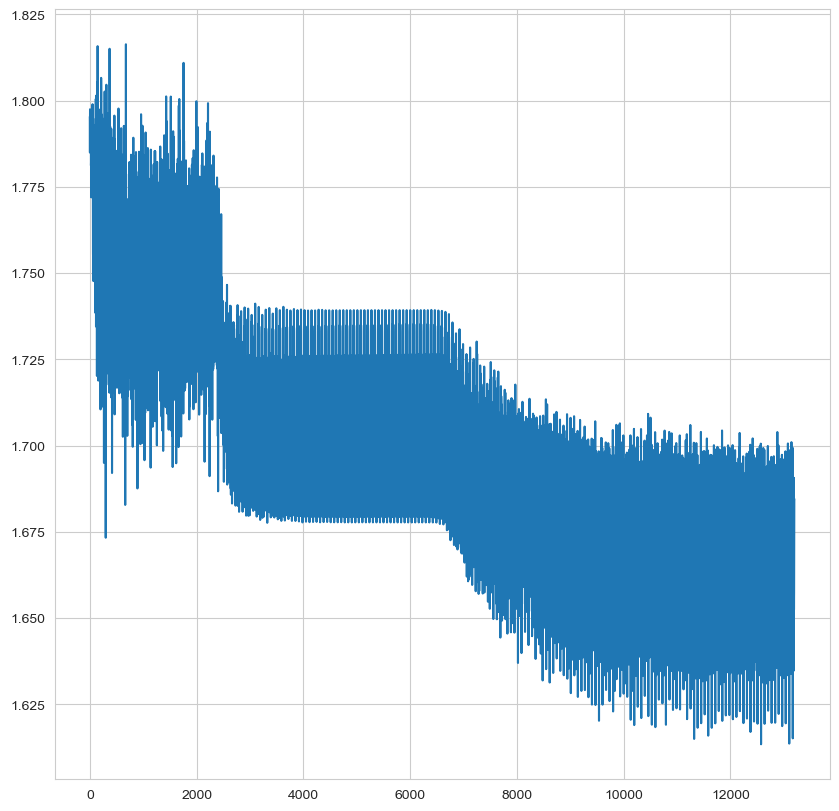

In [113]:
params = {
    'layers': 50,
    'neurons': 800,
    'learning_rate': 4e-4,
    'l2': 5e-3,
    'dropout_rate': 0.75,
    'batch_size': 256,
    'epochs': 200
}

test_NN(NN(**params).to(device))

278.9229509830475
Train accuracy tensor(0.4655, device='cuda:0')
Test accuracy tensor(0.4031, device='cuda:0')
Train ROC_AUC 0.7582905844584037
Test ROC_AUC 0.7096359259987235


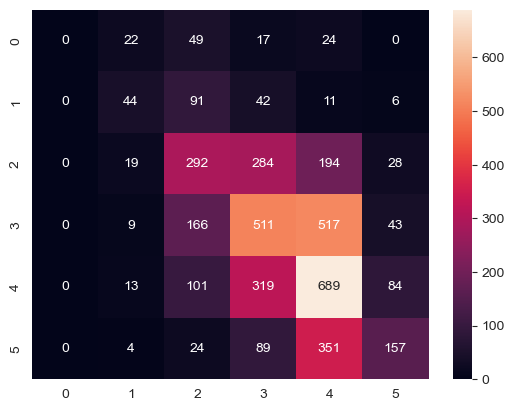

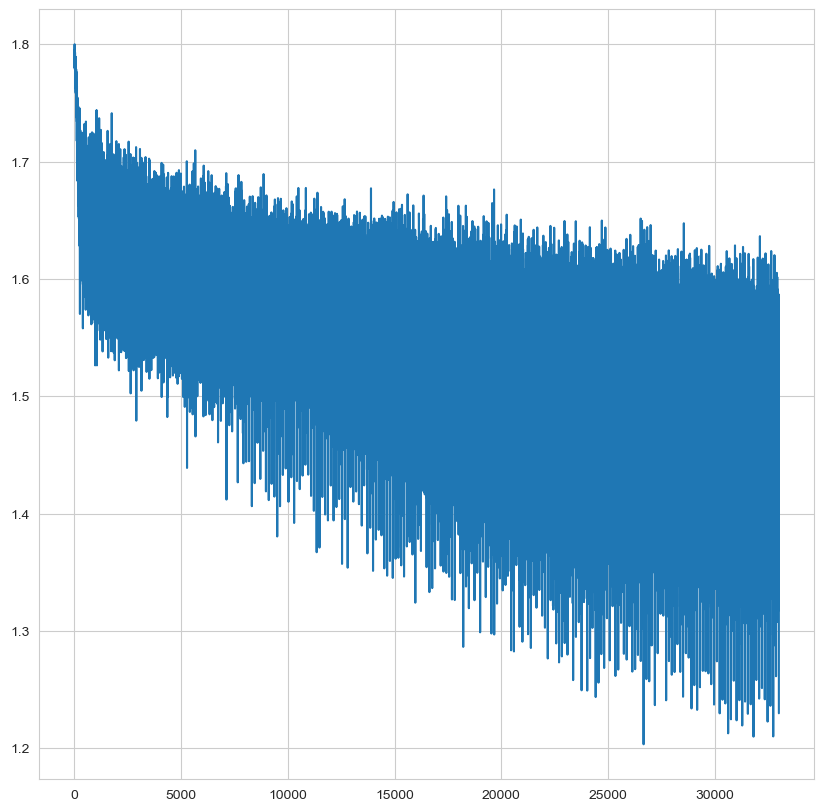

In [116]:
params = {
    'layers': 10,
    'neurons': 400,
    'learning_rate': 1e-4,
    'l2': 1e-3,
    'dropout_rate': 0.5,
    'batch_size': 128,
    'epochs': 250
}

test_NN(NN(**params).to(device))

668.769248008728
Train accuracy tensor(0.4171, device='cuda:0')
Test accuracy tensor(0.3879, device='cuda:0')
Train ROC_AUC 0.6331362412708241
Test ROC_AUC 0.6177275106790935


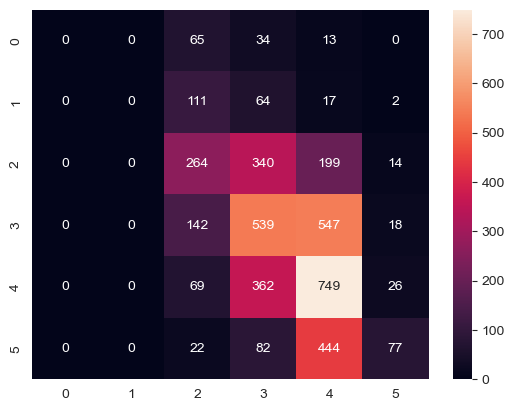

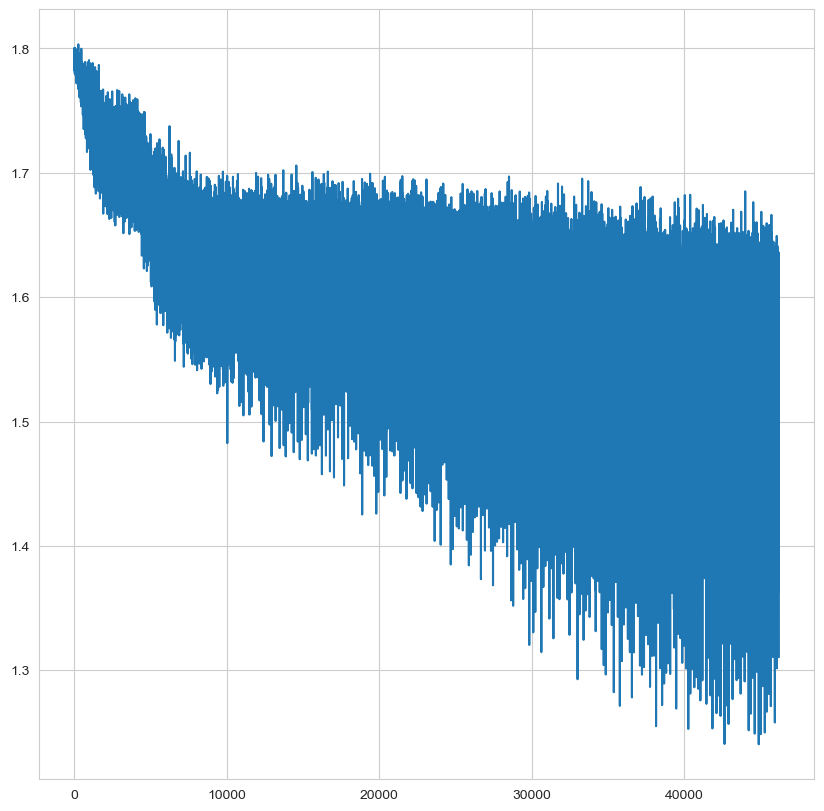

In [118]:
params = {
    'layers': 15,
    'neurons': 400,
    'learning_rate': 1e-4,
    'l2': 1e-3,
    'dropout_rate': 0.75,
    'batch_size': 128,
    'epochs': 350
}

test_NN(NN(**params).to(device))